# Импорт данных и загрузка данных

Датасет: https://www.kaggle.com/datasets/laotse/credit-risk-dataset?resource=download

In [ ]:
!pip install optuna

In [ ]:
# Скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import os
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import optuna

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

In [ ]:
# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")
print("Путь к датасету:", path)

# Показываем все файлы
print("\nФайлы в датасете:")
files = os.listdir(path)
for f in files:
    print(f)

# Пробуем прочитать первый CSV-файл
csv_files = [f for f in files if f.endswith('.csv')]
if csv_files:
    filename = csv_files[0]
    df = pd.read_csv(os.path.join(path, filename))
    print(f"\nУспешно загружен файл: {filename}")

    # Нормализация названий столбцов
    if df is not None:
        df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
        print("Столбцы нормализованы.")
    else:
        print("Ошибка: df не загружен.")
else:
    print("CSV-файлы не найдены.")
    df = None

Путь к датасету: /kaggle/input/credit-risk-dataset

Файлы в датасете:
credit_risk_dataset.csv

Успешно загружен файл: credit_risk_dataset.csv
Столбцы нормализованы.


In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Первичная очистка

## Общая статистика

### Размер датасета

In [ ]:
print(f"Размер датасета: {df.shape}")

Размер датасета: (32581, 12)


### Первые 5 строк

In [ ]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Типы данных

In [ ]:
# df.dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**Вывод:**
1. Датасет содержит 32571 строк и 12 столбцов
2. Есть как числовые (int, float), так и категориальные (object) признаки.
3. Признаки включают: возраст, доход, статус кредита и т.д.

## Числовые данные

### Дубликаты

In [ ]:
duplicates = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates}")

Количество дубликатов: 165


In [ ]:
# Просмотр размера до удаления дубликатов
print(f"Размер датасета до удаления дубликатов: {df.shape}")

# Удаление полных дубликатов (по всем столбцам)
df_cleaned = df.drop_duplicates()

# Просмотр размера после удаления
print(f"Размер датасета после удаления дубликатов: {df_cleaned.shape}")

Размер датасета до удаления дубликатов: (32581, 12)
Размер датасета после удаления дубликатов: (32416, 12)


### Исправление типов данных

In [ ]:
data = df_cleaned.copy()

In [ ]:
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

### Просмотр уникальных столбцов
Если есть удалить

In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

unique_df = data[numeric_cols].nunique().to_frame(name='Unique_Count')
unique_df['Total_Count'] = len(data)
unique_df['% Unique'] = (unique_df['Unique_Count'] / unique_df['Total_Count']) * 100

print(unique_df)

                            Unique_Count  Total_Count   % Unique
person_age                            58        32416   0.178924
person_income                       4295        32416  13.249630
person_emp_length                     36        32416   0.111056
loan_amnt                            753        32416   2.322927
loan_int_rate                        348        32416   1.073544
loan_status                            2        32416   0.006170
loan_percent_income                   77        32416   0.237537
cb_person_default_on_file              2        32416   0.006170
cb_person_cred_hist_length            29        32416   0.089462


### Посмотреть какие признаки непрерывные, а какие дискретные

In [ ]:
def classify_numeric_type(series, threshold=100):
    n_unique = series.nunique()
    if n_unique < threshold:
        return 'Discrete'
    else:
        return 'Continuous'

# Применяем
types = {}
for col in numeric_cols:
    types[col] = classify_numeric_type(data[col])

print("Типы числовых признаков:")
print(pd.Series(types))

Типы числовых признаков:
person_age                      Discrete
person_income                 Continuous
person_emp_length               Discrete
loan_amnt                     Continuous
loan_int_rate                 Continuous
loan_status                     Discrete
loan_percent_income             Discrete
cb_person_default_on_file       Discrete
cb_person_cred_hist_length      Discrete
dtype: object


### Какие признаки являются категориальными

In [ ]:
# Числовые признаки, которые почти категориальные
almost_categorical = data[numeric_cols].nunique()[data[numeric_cols].nunique() < 20]

print("Почти категориальные числовые признаки:")
print(almost_categorical)

Почти категориальные числовые признаки:
loan_status                  2
cb_person_default_on_file    2
dtype: int64


## Категориальные данные

### Преобразование всех не числовых признаков на категориальные

In [ ]:
data.memory_usage(deep=True).sum()  # object — много

np.int64(7897405)

In [ ]:
# Проверка: какие столбцы не числовые (object, string)
non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Нечисловые признаки найдены:")
print(non_numeric_cols)

# Преобразуем все нечисловые столбцы в 'category'
data[non_numeric_cols] = data[non_numeric_cols].astype('category')

# Проверка результата
print("\nТипы данных после преобразования:")
print(data.dtypes)

Нечисловые признаки найдены:
['person_home_ownership', 'loan_intent', 'loan_grade']

Типы данных после преобразования:
person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length              float64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_status                      int64
loan_percent_income            float64
cb_person_default_on_file        int64
cb_person_cred_hist_length       int64
dtype: object


In [ ]:
data.memory_usage(deep=True).sum()  # category — в разы меньше

np.int64(2692095)

### Исправление опечаток и несогласованности

In [ ]:
# Получаем список категориальных столбцов
categorical_cols = data.select_dtypes(include=['category', 'object']).columns.tolist()

print("Категориальные признаки:", categorical_cols)

Категориальные признаки: ['person_home_ownership', 'loan_intent', 'loan_grade']


In [ ]:
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(data[col].value_counts())


--- person_home_ownership ---
person_home_ownership
RENT        16378
MORTGAGE    13369
OWN          2563
OTHER         106
Name: count, dtype: int64

--- loan_intent ---
loan_intent
EDUCATION            6411
MEDICAL              6042
VENTURE              5682
PERSONAL             5498
DEBTCONSOLIDATION    5189
HOMEIMPROVEMENT      3594
Name: count, dtype: int64

--- loan_grade ---
loan_grade
A    10703
B    10387
C     6438
D     3620
E      963
F      241
G       64
Name: count, dtype: int64


**Вывод:**
1. Провел перчиную очистку данных
2. Просмотрел общую статистику
3. Поработал с числовыми признаками
4. Преобразовал категориальные признаки в category для экономия памяти

# Первичный EDA

## Анализ пропусков

In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,887,2.74
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3095,9.55
loan_status,0,0.00
loan_percent_income,0,0.00


                   Пропуски  Процент
person_emp_length       887     2.74
loan_int_rate          3095     9.55


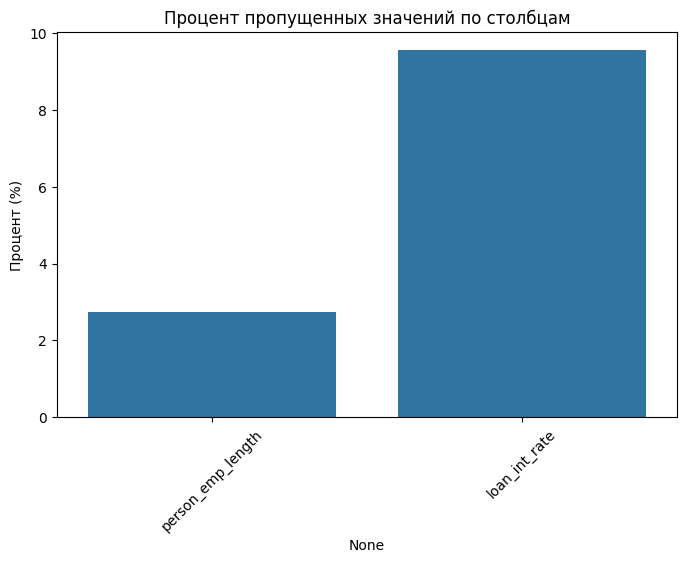

In [ ]:
missing_df = missing_df[missing_df['Пропуски'] > 0]

if missing_df.empty:
    print("❌ Пропущенных значений нет.")
else:
    print(missing_df)
    # Визуализация
    plt.figure(figsize=(8, 5))
    sns.barplot(x=missing_df.index, y=missing_df['Процент'])
    plt.title("Процент пропущенных значений по столбцам")
    plt.ylabel("Процент (%)")
    plt.xticks(rotation=45)
    plt.show()

## Поиск выбросов (IQR)

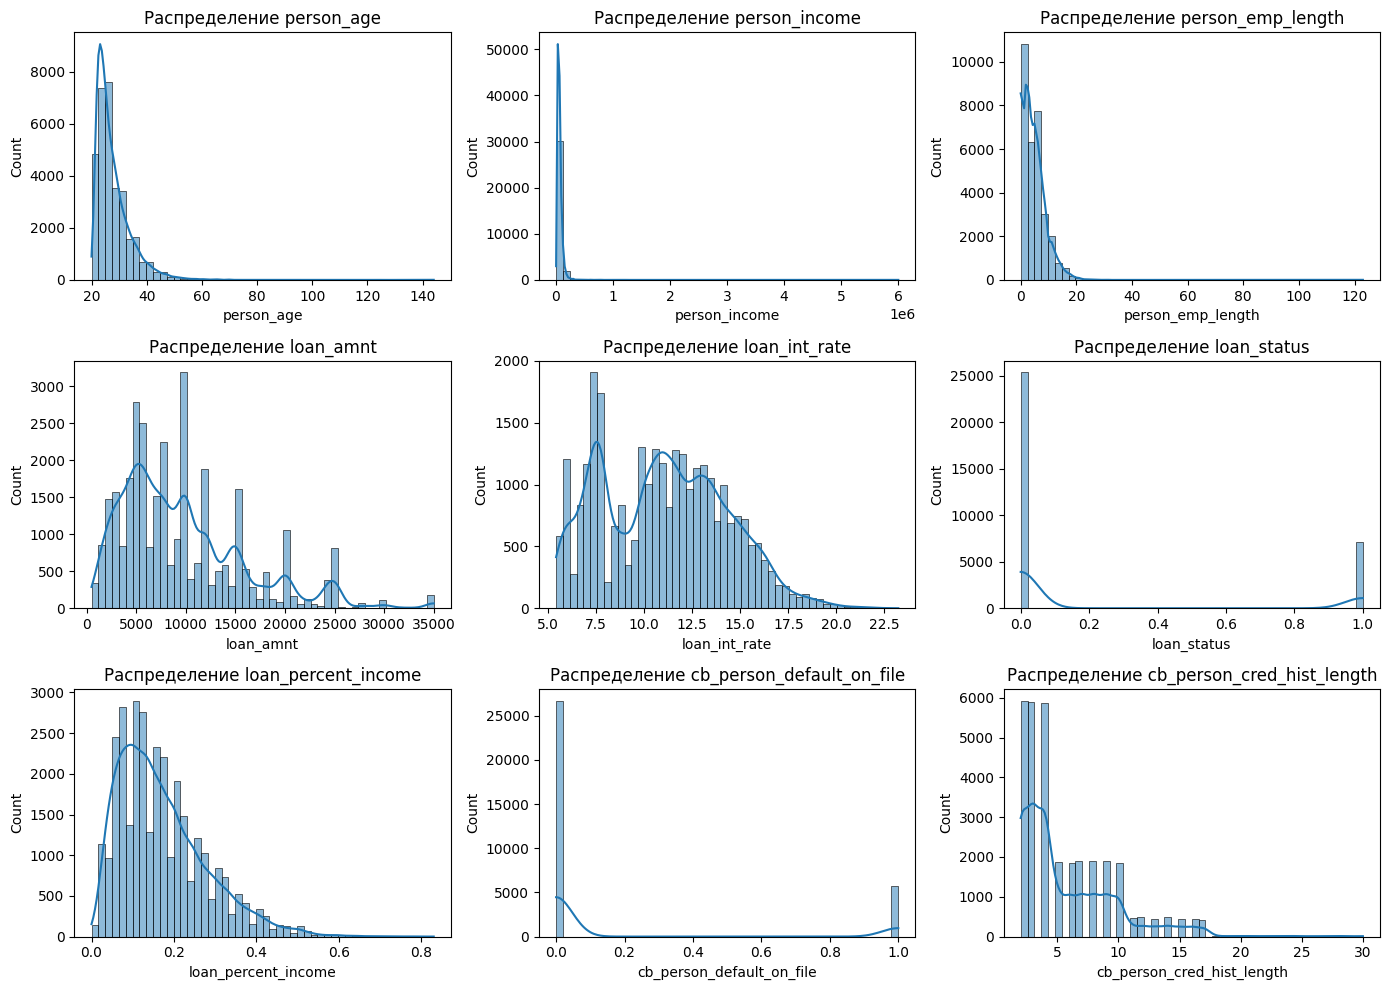

In [ ]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col].dropna(), bins=50, kde=True)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers_iqr(series):
    if not np.issubdtype(series.dtype, np.number):
        raise TypeError("Данные должны быть числовыми")

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Анализ выбросов (без обработки пропусков):")
print("="*60)

for col in numeric_cols:
    clean_data = data[col].dropna()
    if len(clean_data) == 0:
        continue

    try:
        outliers, low, high = detect_outliers_iqr(clean_data)
        percentage = len(outliers) / len(clean_data) * 100
        print(f"{col:25} | {len(outliers):4} выбросов | {percentage:5.2f}% | ({low:.2f}, {high:.2f})")
    except Exception as e:
        print(f"{col:25} | Ошибка: {e}")

Анализ выбросов (без обработки пропусков):
person_age                | 1491 выбросов |  4.60% | (12.50, 40.50)
person_income             | 1478 выбросов |  4.56% | (-22472.00, 140232.00)
person_emp_length         |  852 выбросов |  2.70% | (-5.50, 14.50)
loan_amnt                 | 1679 выбросов |  5.18% | (-5875.00, 23125.00)
loan_int_rate             |    6 выбросов |  0.02% | (-0.46, 21.83)
loan_status               | 7089 выбросов | 21.87% | (0.00, 0.00)
loan_percent_income       |  650 выбросов |  2.01% | (-0.12, 0.44)
cb_person_default_on_file | 5730 выбросов | 17.68% | (0.00, 0.00)
cb_person_cred_hist_length | 1139 выбросов |  3.51% | (-4.50, 15.50)


**Вывод:**
- PERSON_AGE:  возраст 144 - это явно выброс
- PERSON_EMP_LENGTH: продолжительность трудовой деятельности не может быть 123


In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,887,2.74
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3095,9.55
loan_status,0,0.00
loan_percent_income,0,0.00


## Анализ целевой переменной

### Распределение классов

In [ ]:
target = 'loan_status'

In [ ]:
сlass_distribution = data[target].value_counts()
print("\nРаспределение классов:")
print(сlass_distribution)

# Процентное соотношение
print("\nПроценты:")
print(data[target].value_counts(normalize=True) * 100)


Распределение классов:
loan_status
0    25327
1     7089
Name: count, dtype: int64

Проценты:
loan_status
0    78.13117
1    21.86883
Name: proportion, dtype: float64


### Визуализация распределения

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.countplot(data=data, x=target)
# plt.title(f'Распределение классов: {target}')
# plt.xlabel('Класс')
# plt.ylabel('Количество')
# plt.xticks(ticks=[0, 1], labels=['Non-default (0)', 'Default (1)'])
# plt.show()

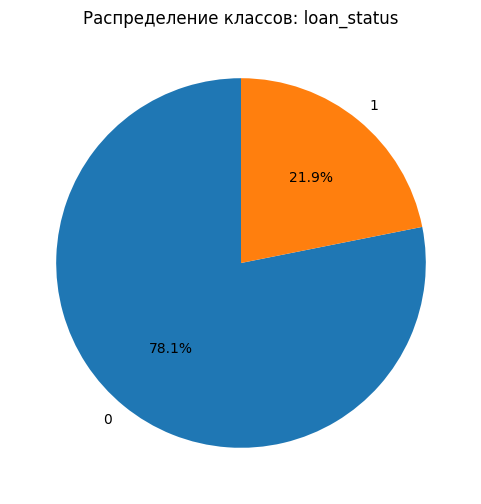

In [ ]:
plt.figure(figsize=(6, 6))
data[target].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title(f'Распределение классов: {target}')
plt.ylabel('')
plt.show()

### Баланс / Дисбаланс классов

Если один класс составляет менее 10–20% — считается дисбалансом.

(дефолт) = 21% → это легкий дисбаланс, поэтому стоит использовать различные метрики и неопираться на Accuracy

## Одномерный анализ

In [ ]:
# Разделим признаки на числовые и категориальные
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()


print(f"Числовые признаки: {numeric_cols}")
print(f"Категориальные признаки: {categorical_cols}")

Числовые признаки: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
Категориальные признаки: ['person_home_ownership', 'loan_intent', 'loan_grade']


### Анализ количественных признаков


🔍 Признак: person_age
Описательная статистика:
count    32581.000000
mean        27.734600
std          6.348078
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64


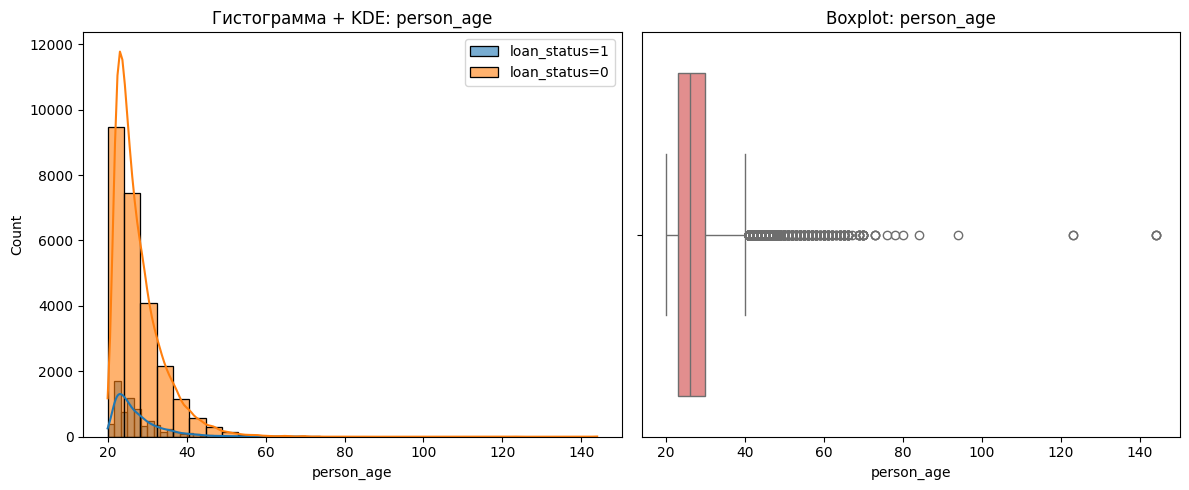


🔍 Признак: person_income
Описательная статистика:
count    3.258100e+04
mean     6.607485e+04
std      6.198312e+04
min      4.000000e+03
25%      3.850000e+04
50%      5.500000e+04
75%      7.920000e+04
max      6.000000e+06
Name: person_income, dtype: float64


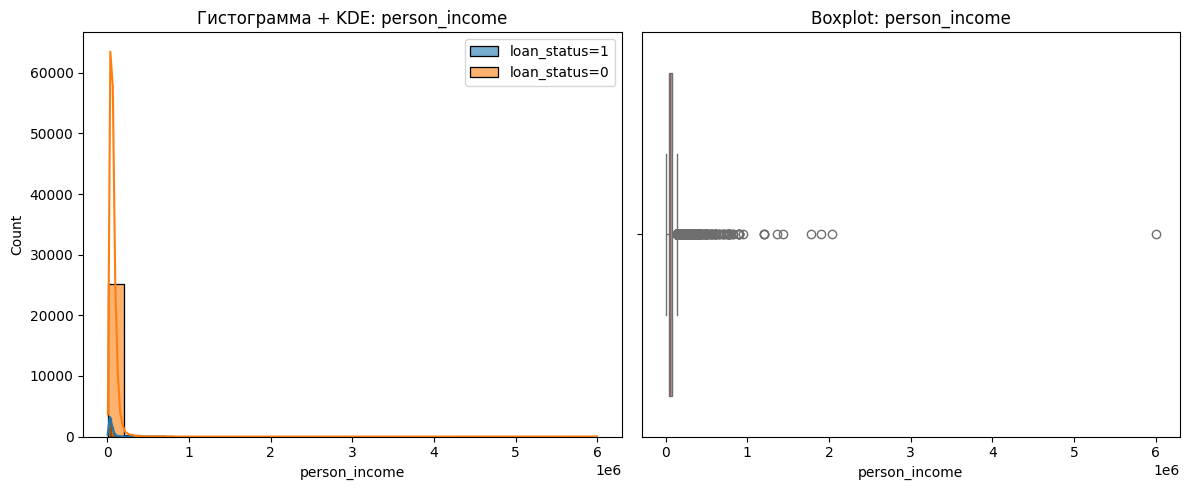


🔍 Признак: person_emp_length
Описательная статистика:
count    31686.000000
mean         4.789686
std          4.142630
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64


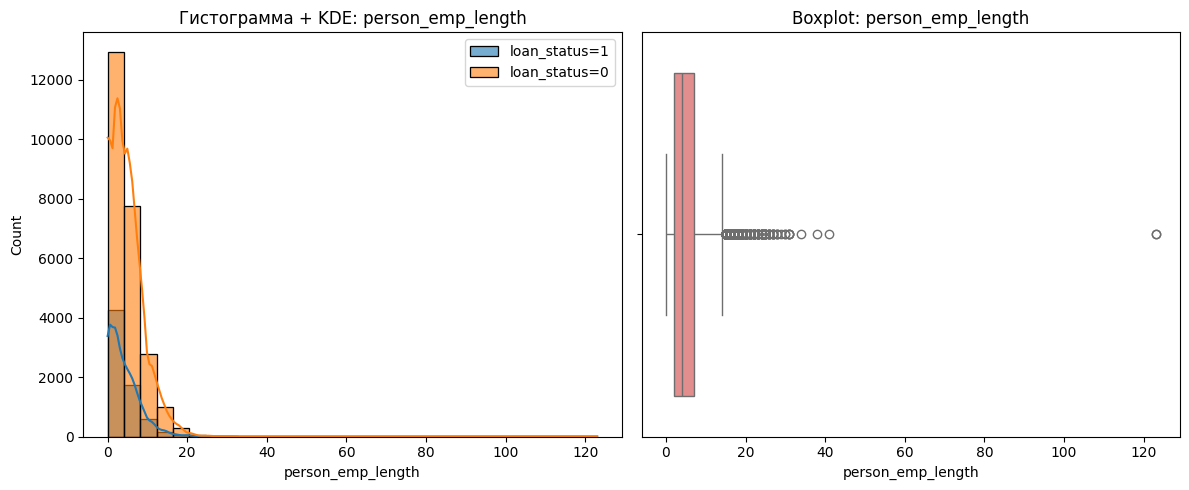


🔍 Признак: loan_amnt
Описательная статистика:
count    32581.000000
mean      9589.371106
std       6322.086646
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12200.000000
max      35000.000000
Name: loan_amnt, dtype: float64


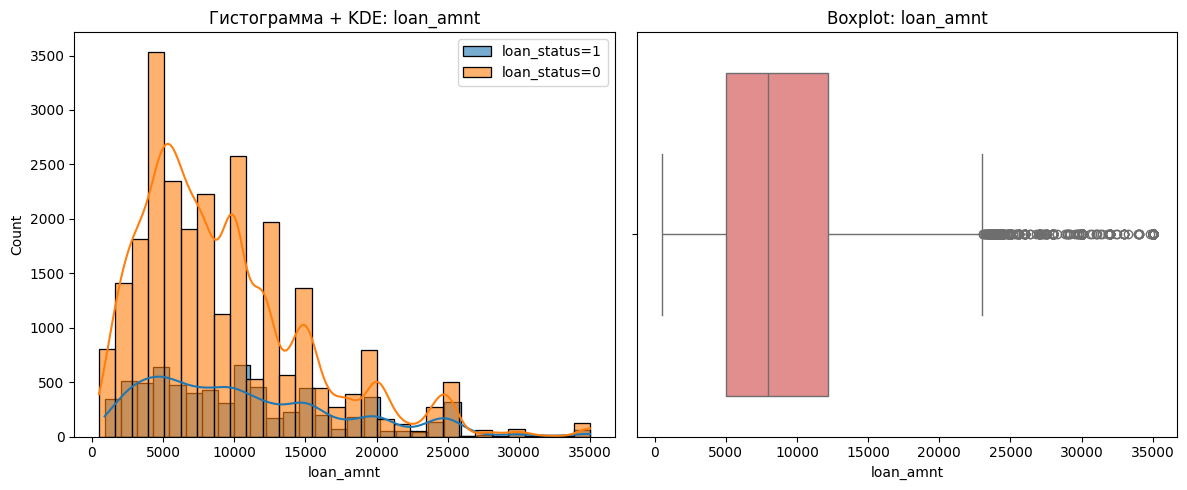


🔍 Признак: loan_int_rate
Описательная статистика:
count    29465.000000
mean        11.011695
std          3.240459
min          5.420000
25%          7.900000
50%         10.990000
75%         13.470000
max         23.220000
Name: loan_int_rate, dtype: float64


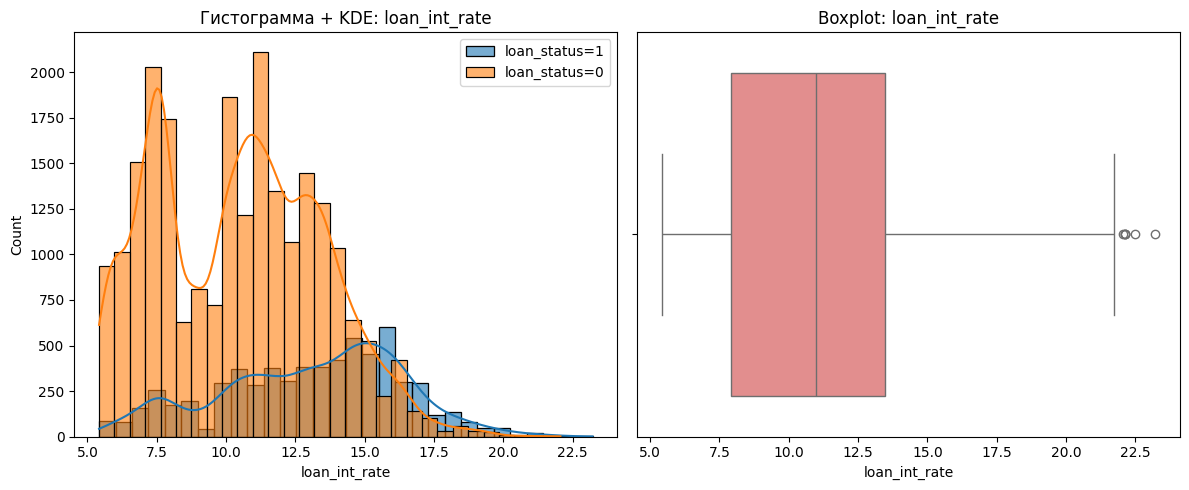


🔍 Признак: loan_status
Описательная статистика:
count    32581.000000
mean         0.218164
std          0.413006
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


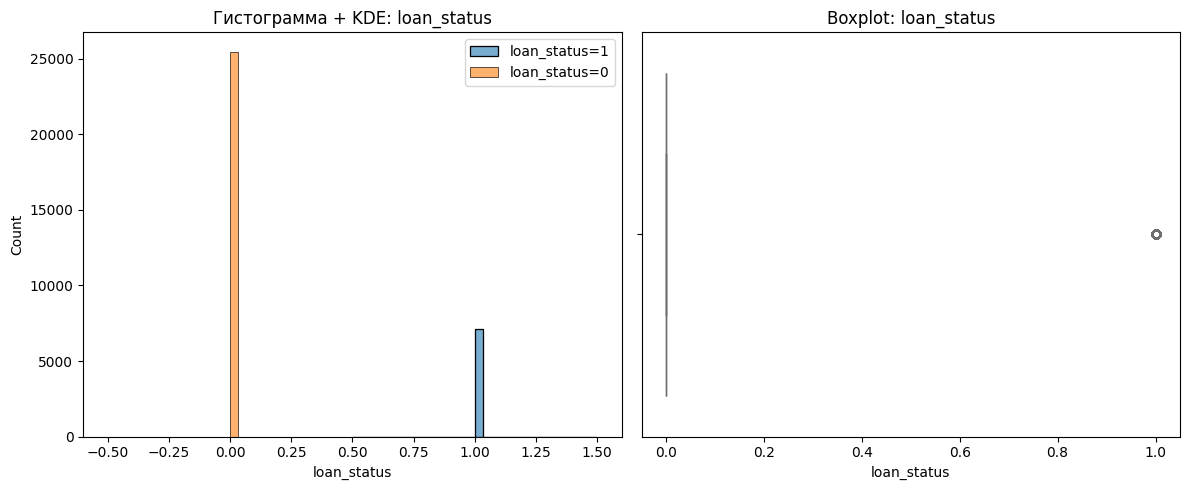


🔍 Признак: loan_percent_income
Описательная статистика:
count    32581.000000
mean         0.170203
std          0.106782
min          0.000000
25%          0.090000
50%          0.150000
75%          0.230000
max          0.830000
Name: loan_percent_income, dtype: float64


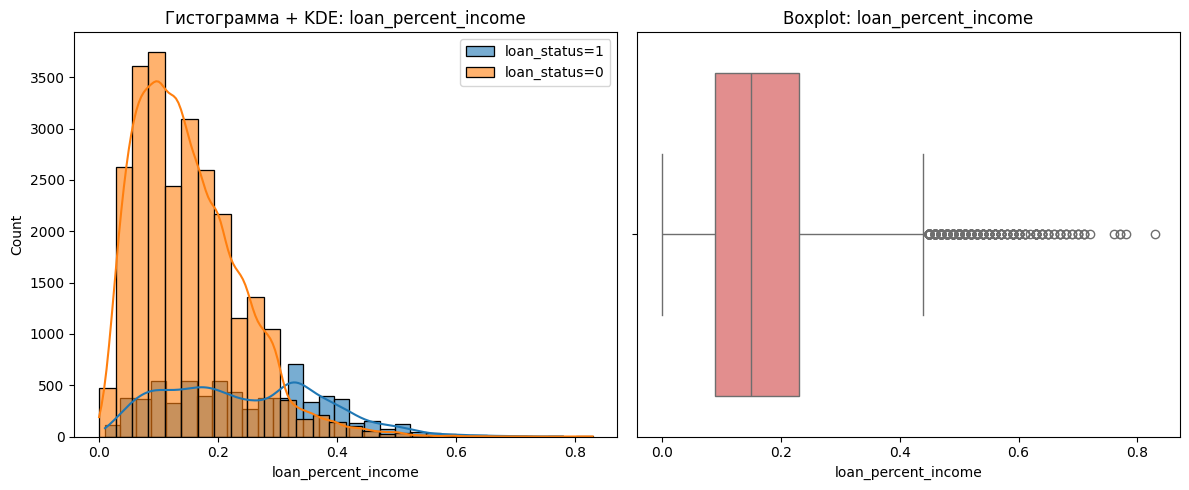


🔍 Признак: cb_person_default_on_file
Описательная статистика:
count     32581
unique        2
top           N
freq      26836
Name: cb_person_default_on_file, dtype: object


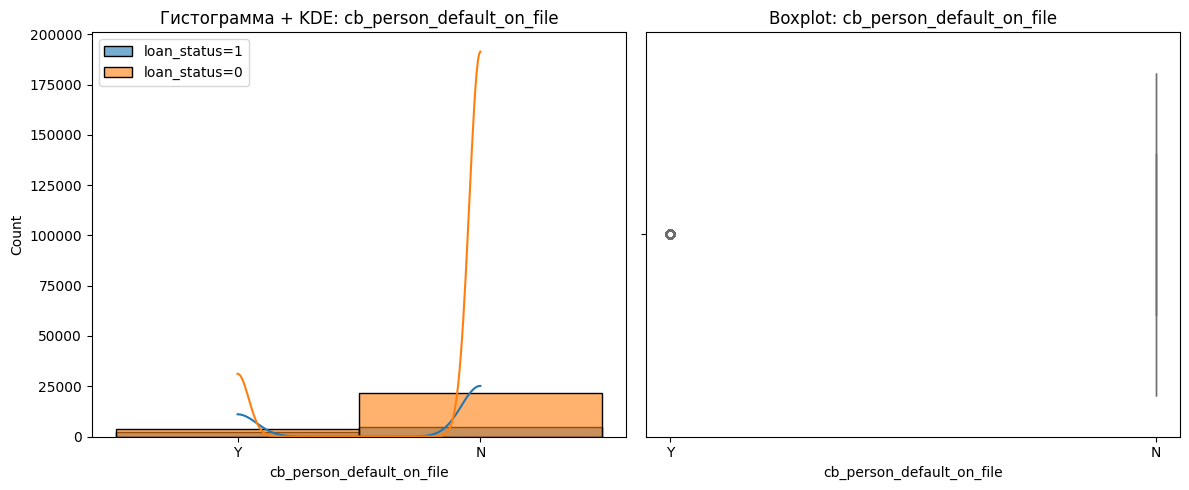


🔍 Признак: cb_person_cred_hist_length
Описательная статистика:
count    32581.000000
mean         5.804211
std          4.055001
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64


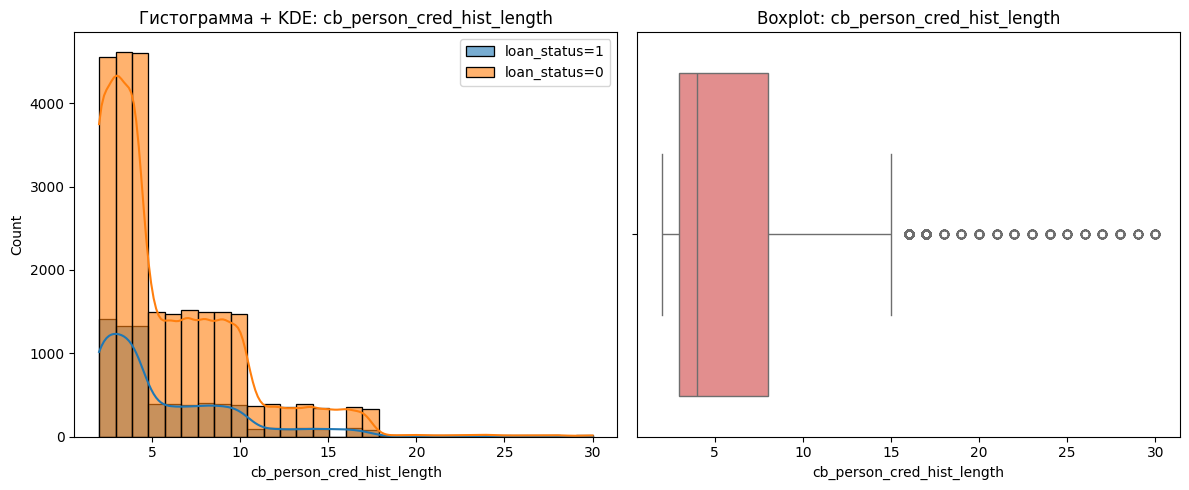

In [ ]:
for col in numeric_cols:
    print(f"\n🔍 Признак: {col}")

    # df.describe()
    print(f"Описательная статистика:")
    print(df[col].describe())

    # Гистограмма + плотность
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for cls in df[target].unique():
        subset = df[df[target] == cls]
        sns.histplot(subset[col], bins=30, kde=True, label=f'{target}={cls}', alpha=0.6)
    plt.legend()
    plt.title(f'Гистограмма + KDE: {col}')
    plt.xlabel(col)

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()

**Вывод:**
Все числовые данные имеют ассиметричное распределение

### Анализ категориальных признаков


🔍 Признак: person_home_ownership
Уникальные значения: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
Частота значений:
person_home_ownership
RENT        50.477272
MORTGAGE    41.263313
OWN          7.931003
OTHER        0.328412
Name: proportion, dtype: float64

Описание:
count     32581
unique        4
top        RENT
freq      16446
Name: person_home_ownership, dtype: object


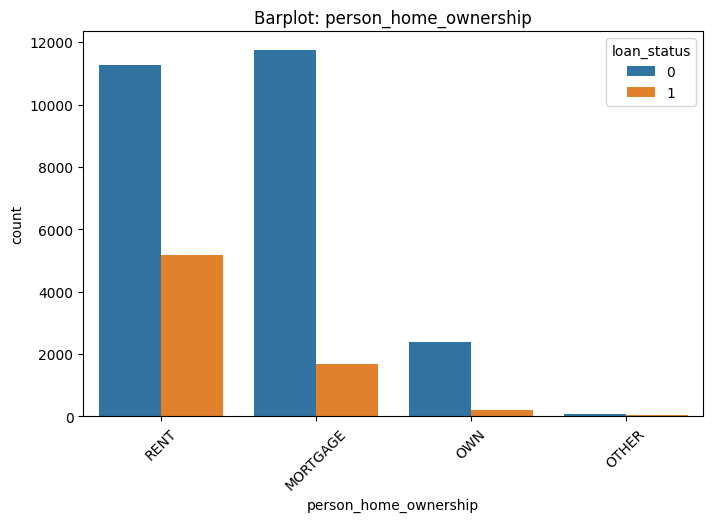


🔍 Признак: loan_intent
Уникальные значения: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
Частота значений:
loan_intent
EDUCATION            19.806022
MEDICAL              18.633559
VENTURE              17.553175
PERSONAL             16.945459
DEBTCONSOLIDATION    15.997053
HOMEIMPROVEMENT      11.064731
Name: proportion, dtype: float64

Описание:
count         32581
unique            6
top       EDUCATION
freq           6453
Name: loan_intent, dtype: object


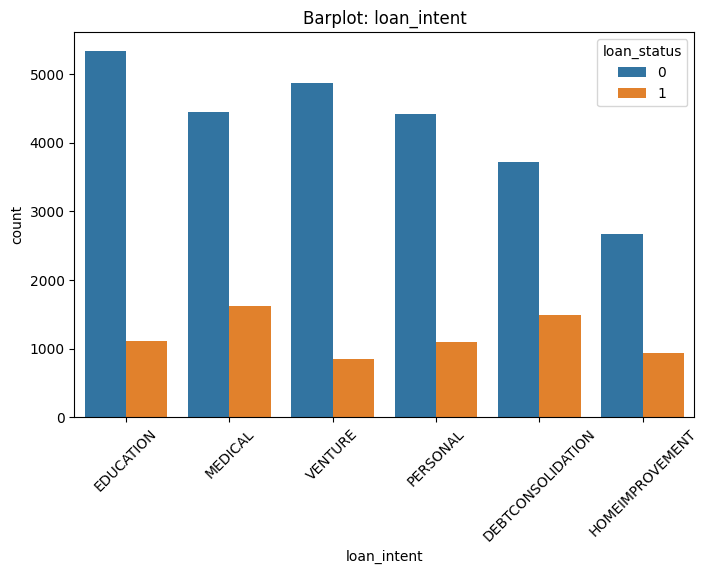


🔍 Признак: loan_grade
Уникальные значения: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
Частота значений:
loan_grade
A    33.077561
B    32.076977
C    19.821368
D    11.129186
E     2.958780
F     0.739695
G     0.196434
Name: proportion, dtype: float64

Описание:
count     32581
unique        7
top           A
freq      10777
Name: loan_grade, dtype: object


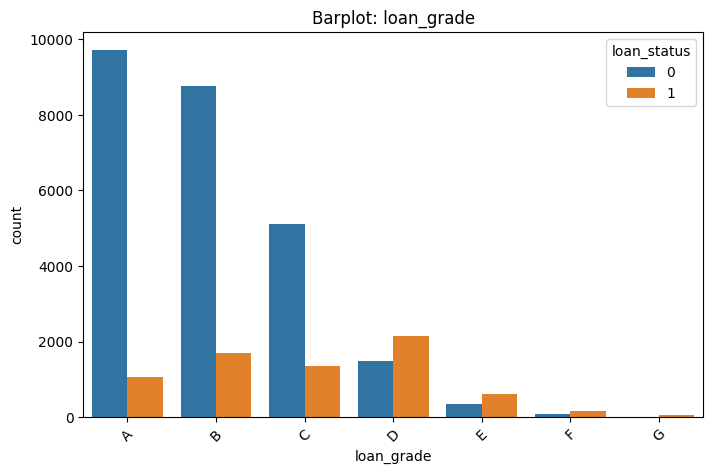

In [ ]:
for col in categorical_cols:
    print(f"\n🔍 Признак: {col}")

    # .unique() и .value_counts()
    unique_values = df[col].unique()
    value_counts = df[col].value_counts(normalize=True) * 100

    print(f"Уникальные значения: {unique_values}")
    print(f"Частота значений:\n{value_counts}")

    # df.describe()
    print(f"\nОписание:")
    print(df[col].describe())

    # Barplot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue=target, order=value_counts.index)
    plt.title(f'Barplot: {col}')
    plt.xticks(rotation=45)
    plt.show()

**Вывод:**
person_home_ownership: большинство людей арендуют житье или у них ипотека. OTHER — можно удалить
loan_intent: большинство кредитов образование, медицина, бизнес
loan_grade: большинство людей имеют хороший рейтинг. Объединить редкие категории: F, G → HIGH_RISK
cb_person_default_on_file: в данном признаке имеет дисбаланс пропорции. Модель должна сильнее взвешивать этот признак. Люди с историей просрочек — высокий риск

OneHotEncoder:

- person_home_ownership ('RENT' 'OWN' 'MORTGAGE' 'OTHER')

- loan_intent ('PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
'DEBTCONSOLIDATION')

LabelEncoder:
- loan_grade ('D' 'B' 'C' 'A' 'E' 'F' 'G')


## Двумерный анализ

### Признак числовой и Целевая переменная (Два числовых)

In [ ]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,895,2.75
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3116,9.56
loan_status,0,0.00
loan_percent_income,0,0.00


In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,887,2.74
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3095,9.55
loan_status,0,0.00
loan_percent_income,0,0.00


In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32416 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  32416 non-null  int64   
 1   person_income               32416 non-null  int64   
 2   person_home_ownership       32416 non-null  category
 3   person_emp_length           31529 non-null  float64 
 4   loan_intent                 32416 non-null  category
 5   loan_grade                  32416 non-null  category
 6   loan_amnt                   32416 non-null  int64   
 7   loan_int_rate               29321 non-null  float64 
 8   loan_status                 32416 non-null  int64   
 9   loan_percent_income         32416 non-null  float64 
 10  cb_person_default_on_file   32416 non-null  int64   
 11  cb_person_cred_hist_length  32416 non-null  int64   
dtypes: category(3), float64(3), int64(6)
memory usage: 2.6 MB


In [ ]:
missing = data.isnull().sum()
missing_percent = (missing / len(data)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,887,2.74
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3095,9.55
loan_status,0,0.00
loan_percent_income,0,0.00


In [ ]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Пропуски': missing,
    'Процент': missing_percent.round(2)
})
missing_df

,Пропуски,Процент
person_age,0,0.00
person_income,0,0.00
person_home_ownership,0,0.00
person_emp_length,887,2.74
loan_intent,0,0.00
loan_grade,0,0.00
loan_amnt,0,0.00
loan_int_rate,3095,9.55
loan_status,0,0.00
loan_percent_income,0,0.00


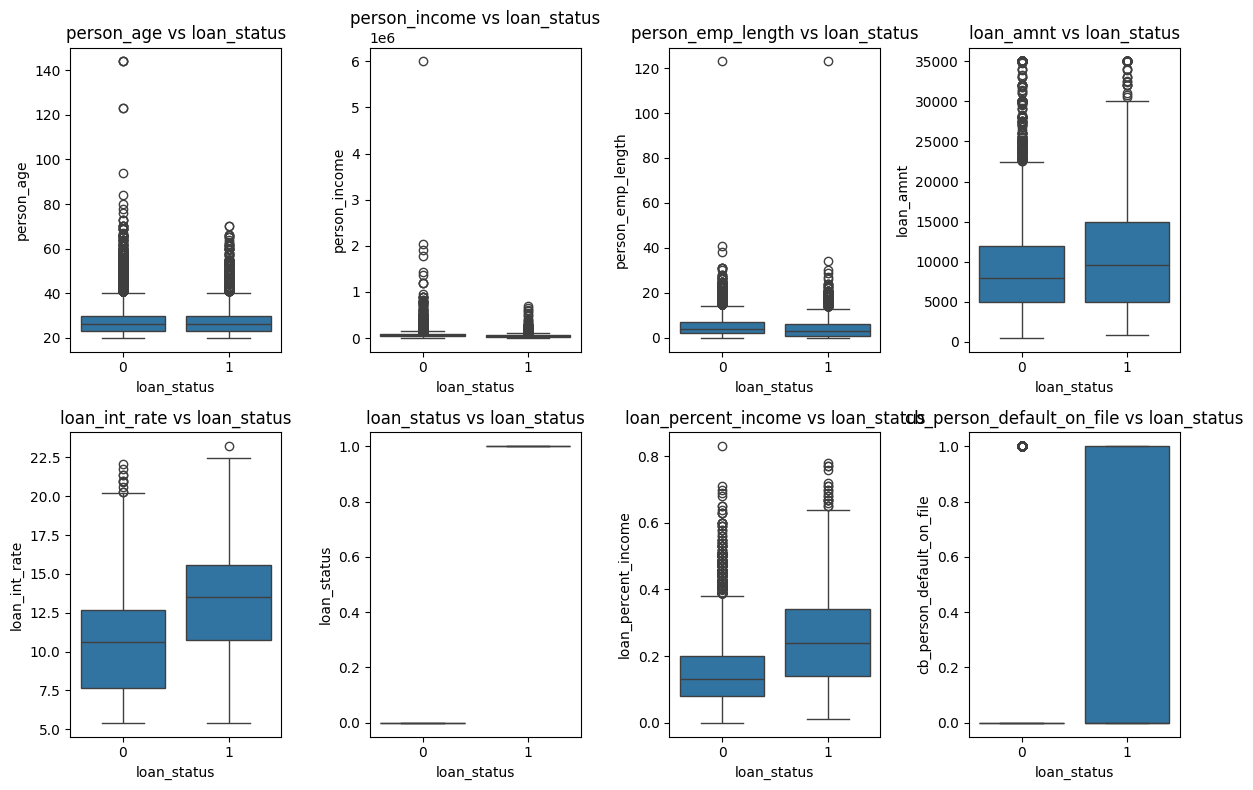

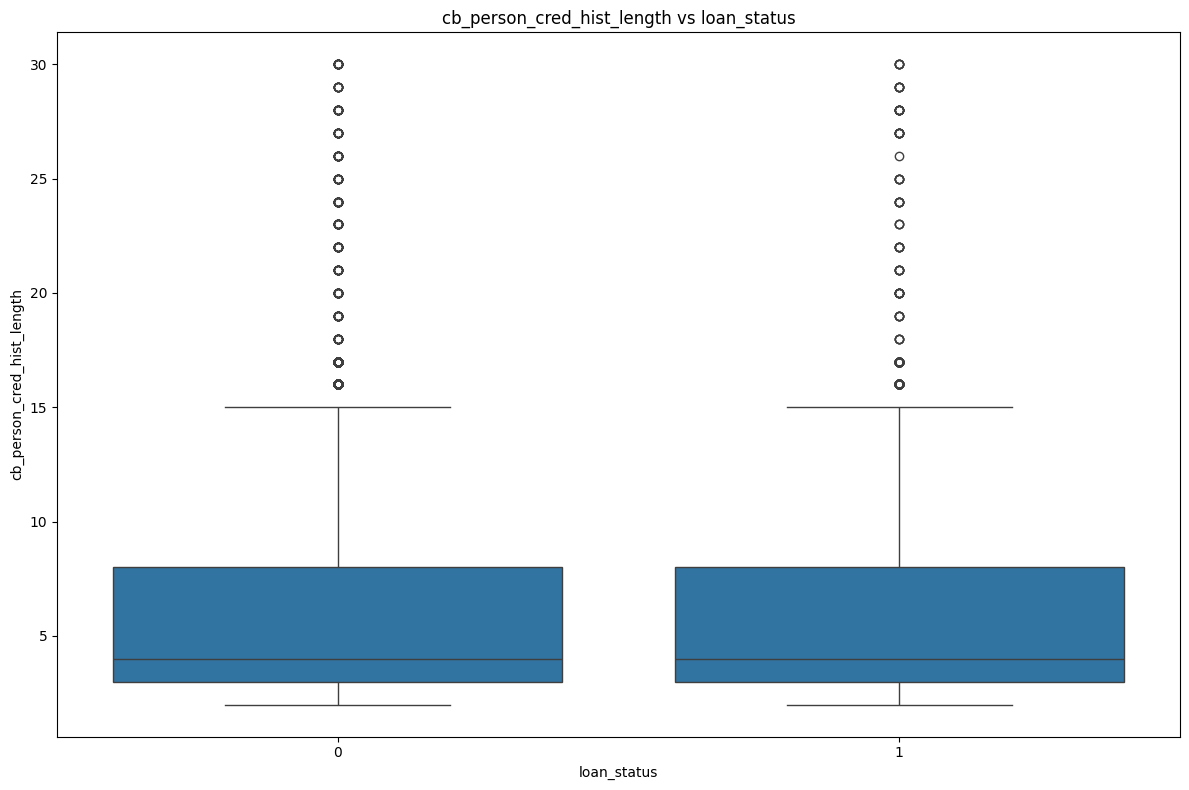

In [ ]:
# Первая часть: первые 8 признаков
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[:8], 1):
    plt.subplot(2, 4, i)
    sns.boxplot(data=df, x=target, y=col)
    # sns.stripplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
plt.tight_layout()
plt.show()

# Вторая часть: оставшиеся
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols[8:], 1):
    plt.subplot(1, 1, i)
    sns.boxplot(data=df, x=target, y=col)
    # sns.stripplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
plt.tight_layout()
plt.show()

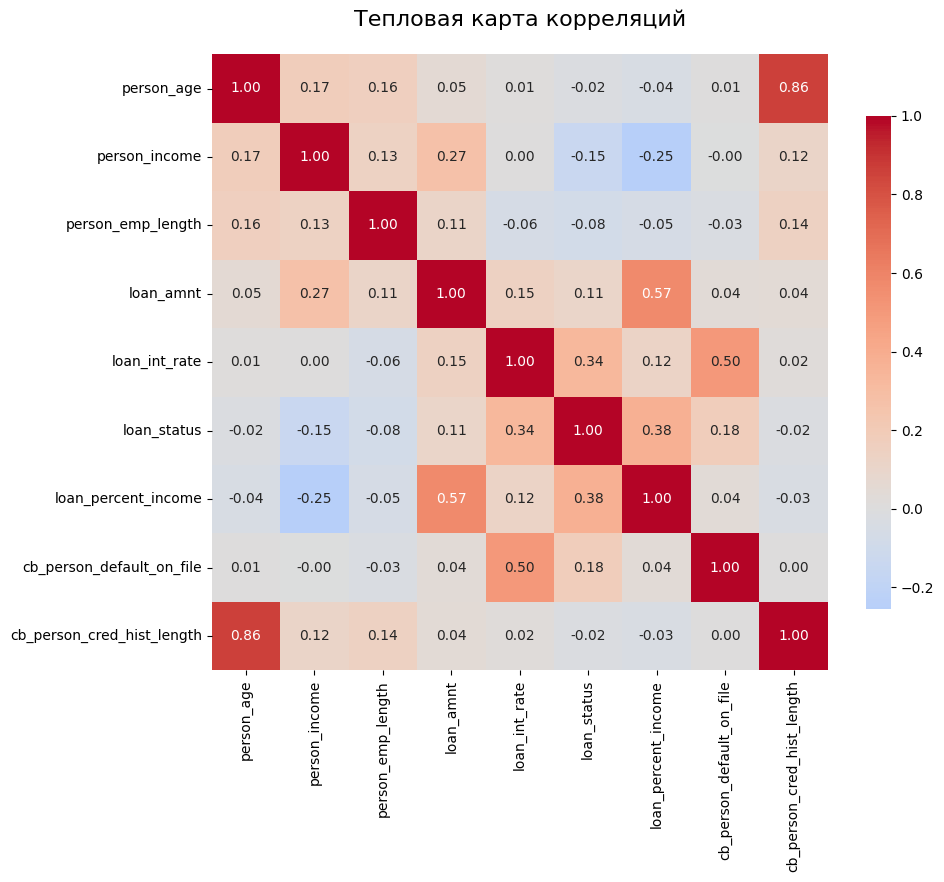

In [ ]:
df_numeric = df[numeric_cols]

# Матрица корреляций
corr_matrix = df_numeric.corr()

# Тепловая карта
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # числа в ячейках
    fmt=".2f",            # 2 знака после запятой
    cmap='coolwarm',      # цвет: красный — +1, синий — -1
    center=0,             # центр на 0
    square=True,          # квадратные ячейки
    cbar_kws={"shrink": 0.8}
)
plt.title('Тепловая карта корреляций', fontsize=16, pad=20)
plt.show()

### Признак числовой и категориальный признак

In [ ]:
# # Разделим признаки на числовые и категориальные
# numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
# categorical_cols = data.select_dtypes(include=['category']).columns.tolist()

# # Для каждого категориального признака и числового — строим violinplot
# for cat_col in categorical_cols:
#     for num_col in numeric_cols:
#         plt.figure(figsize=(8, 4))
#         sns.violinplot(x=cat_col, y=num_col, data=df)
#         plt.title(f'{num_col} по {cat_col}')
#         plt.tight_layout()
#         plt.show()

### Категориальные признаки и целевая переменная

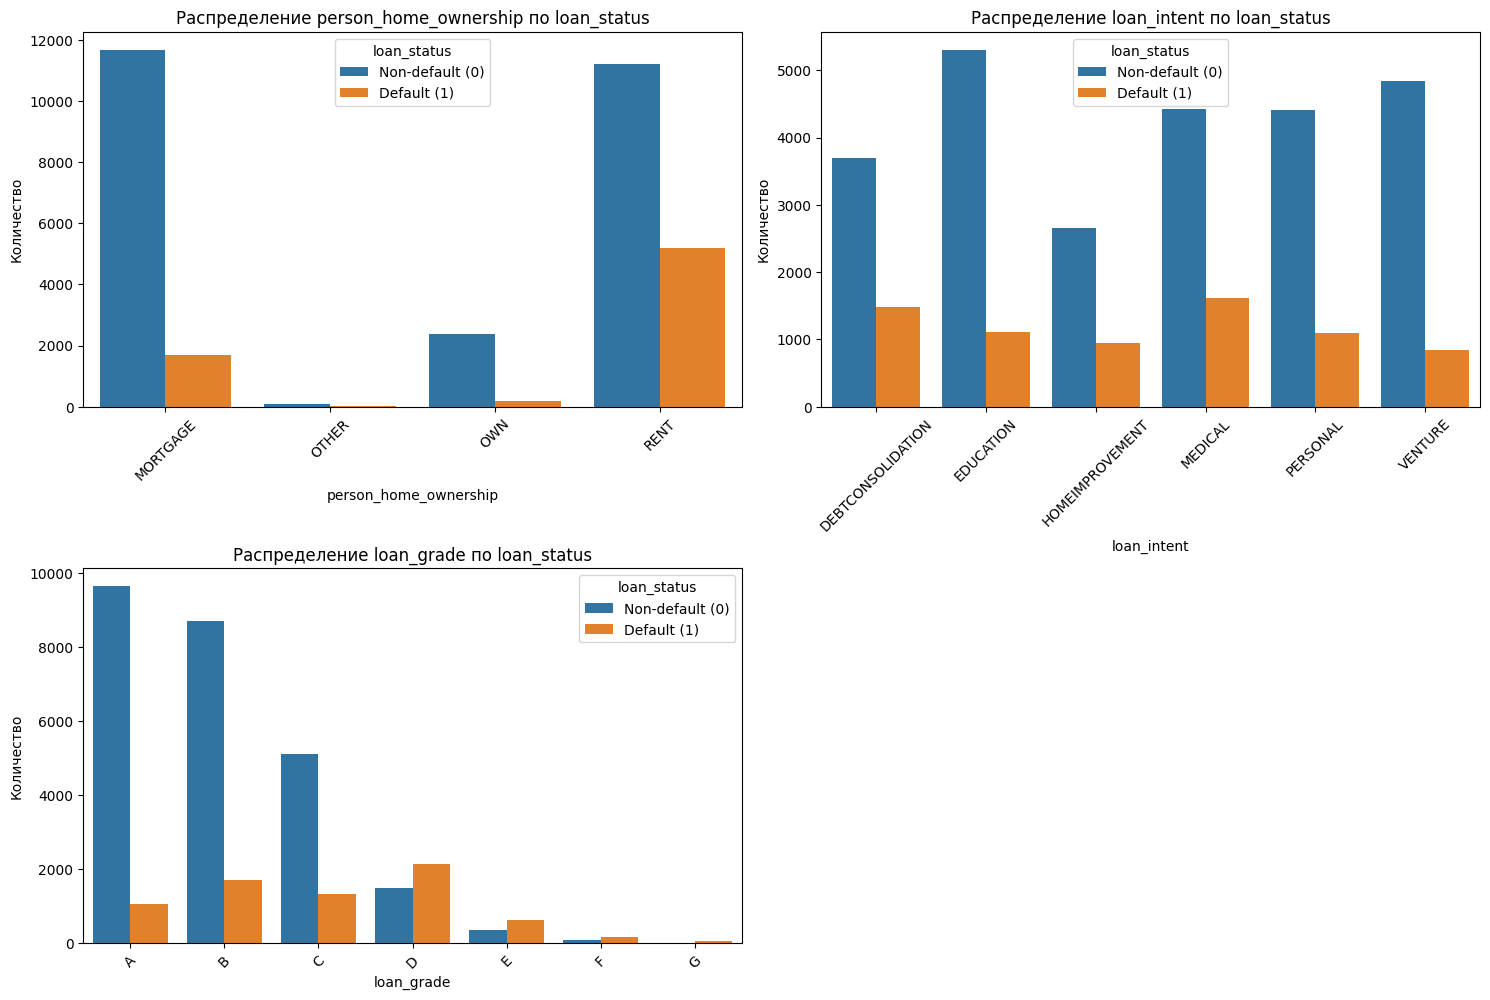

In [ ]:
plt.figure(figsize=(15, len(categorical_cols) * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 2, i)
    sns.countplot(data=df, x=col, hue=target)
    plt.title(f'Распределение {col} по {target}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.legend(title=target, labels=['Non-default (0)', 'Default (1)'])

plt.tight_layout()
plt.show()

# Логическая предобработка

## Числовые признаки

### Заполнение пропусков

In [ ]:
df.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3095
loan_status,0
loan_percent_income,0


In [ ]:
df['person_emp_length'].head()

,person_emp_length
0,123.0
1,5.0
2,1.0
3,4.0
4,8.0


In [ ]:
df['person_emp_length'] = df['person_emp_length'].fillna(0)

In [ ]:
df['loan_int_rate'].head()

,loan_int_rate
0,16.02
1,11.14
2,12.87
3,15.23
4,14.27


loan_int_rate признак обработаю только после разделения данных. Средними данными, потому что если сейчас заполнить, то будет утечка данных

### Обработка выбросов

In [ ]:
data_one = df.copy()

In [ ]:
def clean_numeric_data(df):
    # Список числовых признаков
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Правила очистки
    rules = {
        'person_age': {'min': 0, 'max': 120}, # Возраст не может быть отрицательным и не может быть слишком большим (например, > 120 лет)
        'person_income': {'min': 0, 'max': 1e20}, # Доход не может быть отрицательным и Доход не может быть чрезмерно высоким (например, > $1M — редко, но возможно)
        'person_emp_length': {'min': 0, 'max': 100}, # Стаж не может быть отрицательным и Стаж не может быть больше возраста
        'loan_amnt': {'min': 0, 'max': 1e10}, # Кредит не может быть отрицательным и Кредит не может быть слишком большим (например, > $1M)
        'loan_int_rate': {'min': 0, 'max': 100}, # Ставка не может быть отрицательной и Ставка не может быть чрезмерно высокой (например, > 100%)
        'loan_percent_income': {'min': 0, 'max': 200}, # Не может быть отрицательной и Максимально разумное значение — например, 200% (хотя и редко)
        'cb_person_cred_hist_length': {'min': 0, 'max': 100} # Не может быть отрицательной и Не может быть больше возраста
    }

    for col in numeric_cols:
        if col in rules:
            min_val, max_val = rules[col]['min'], rules[col]['max']

            # Работаем только с непустыми значениями
            mask = df[col].notna()
            # Заменяем выбросы на NaN (или удаляем — но не сейчас)
            df.loc[mask, col] = df.loc[mask, col].where(
                (df.loc[mask, col] >= min_val) & (df.loc[mask, col] <= max_val)
            )

    return df

In [ ]:
df = clean_numeric_data(df)

In [ ]:
print(f"Осталось строк: {len(df)}")
print(f"Удалено строк: {len(data_one) - len(df)}")
print((len(data_one) - len(df)) / len(df) * 100)

Осталось строк: 32416
Удалено строк: 0
0.0


In [ ]:
# Проверка: стаж не может быть больше возраста
df = df[df['person_emp_length'] <= df['person_age']]

# Проверка: кредитная история не может быть больше возраста
df = df[df['cb_person_cred_hist_length'] <= df['person_age']]

In [ ]:
df.shape

(32409, 12)

### Просморт выбросов снова и логарифмирование

Анализирую 8 числовых признаков: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


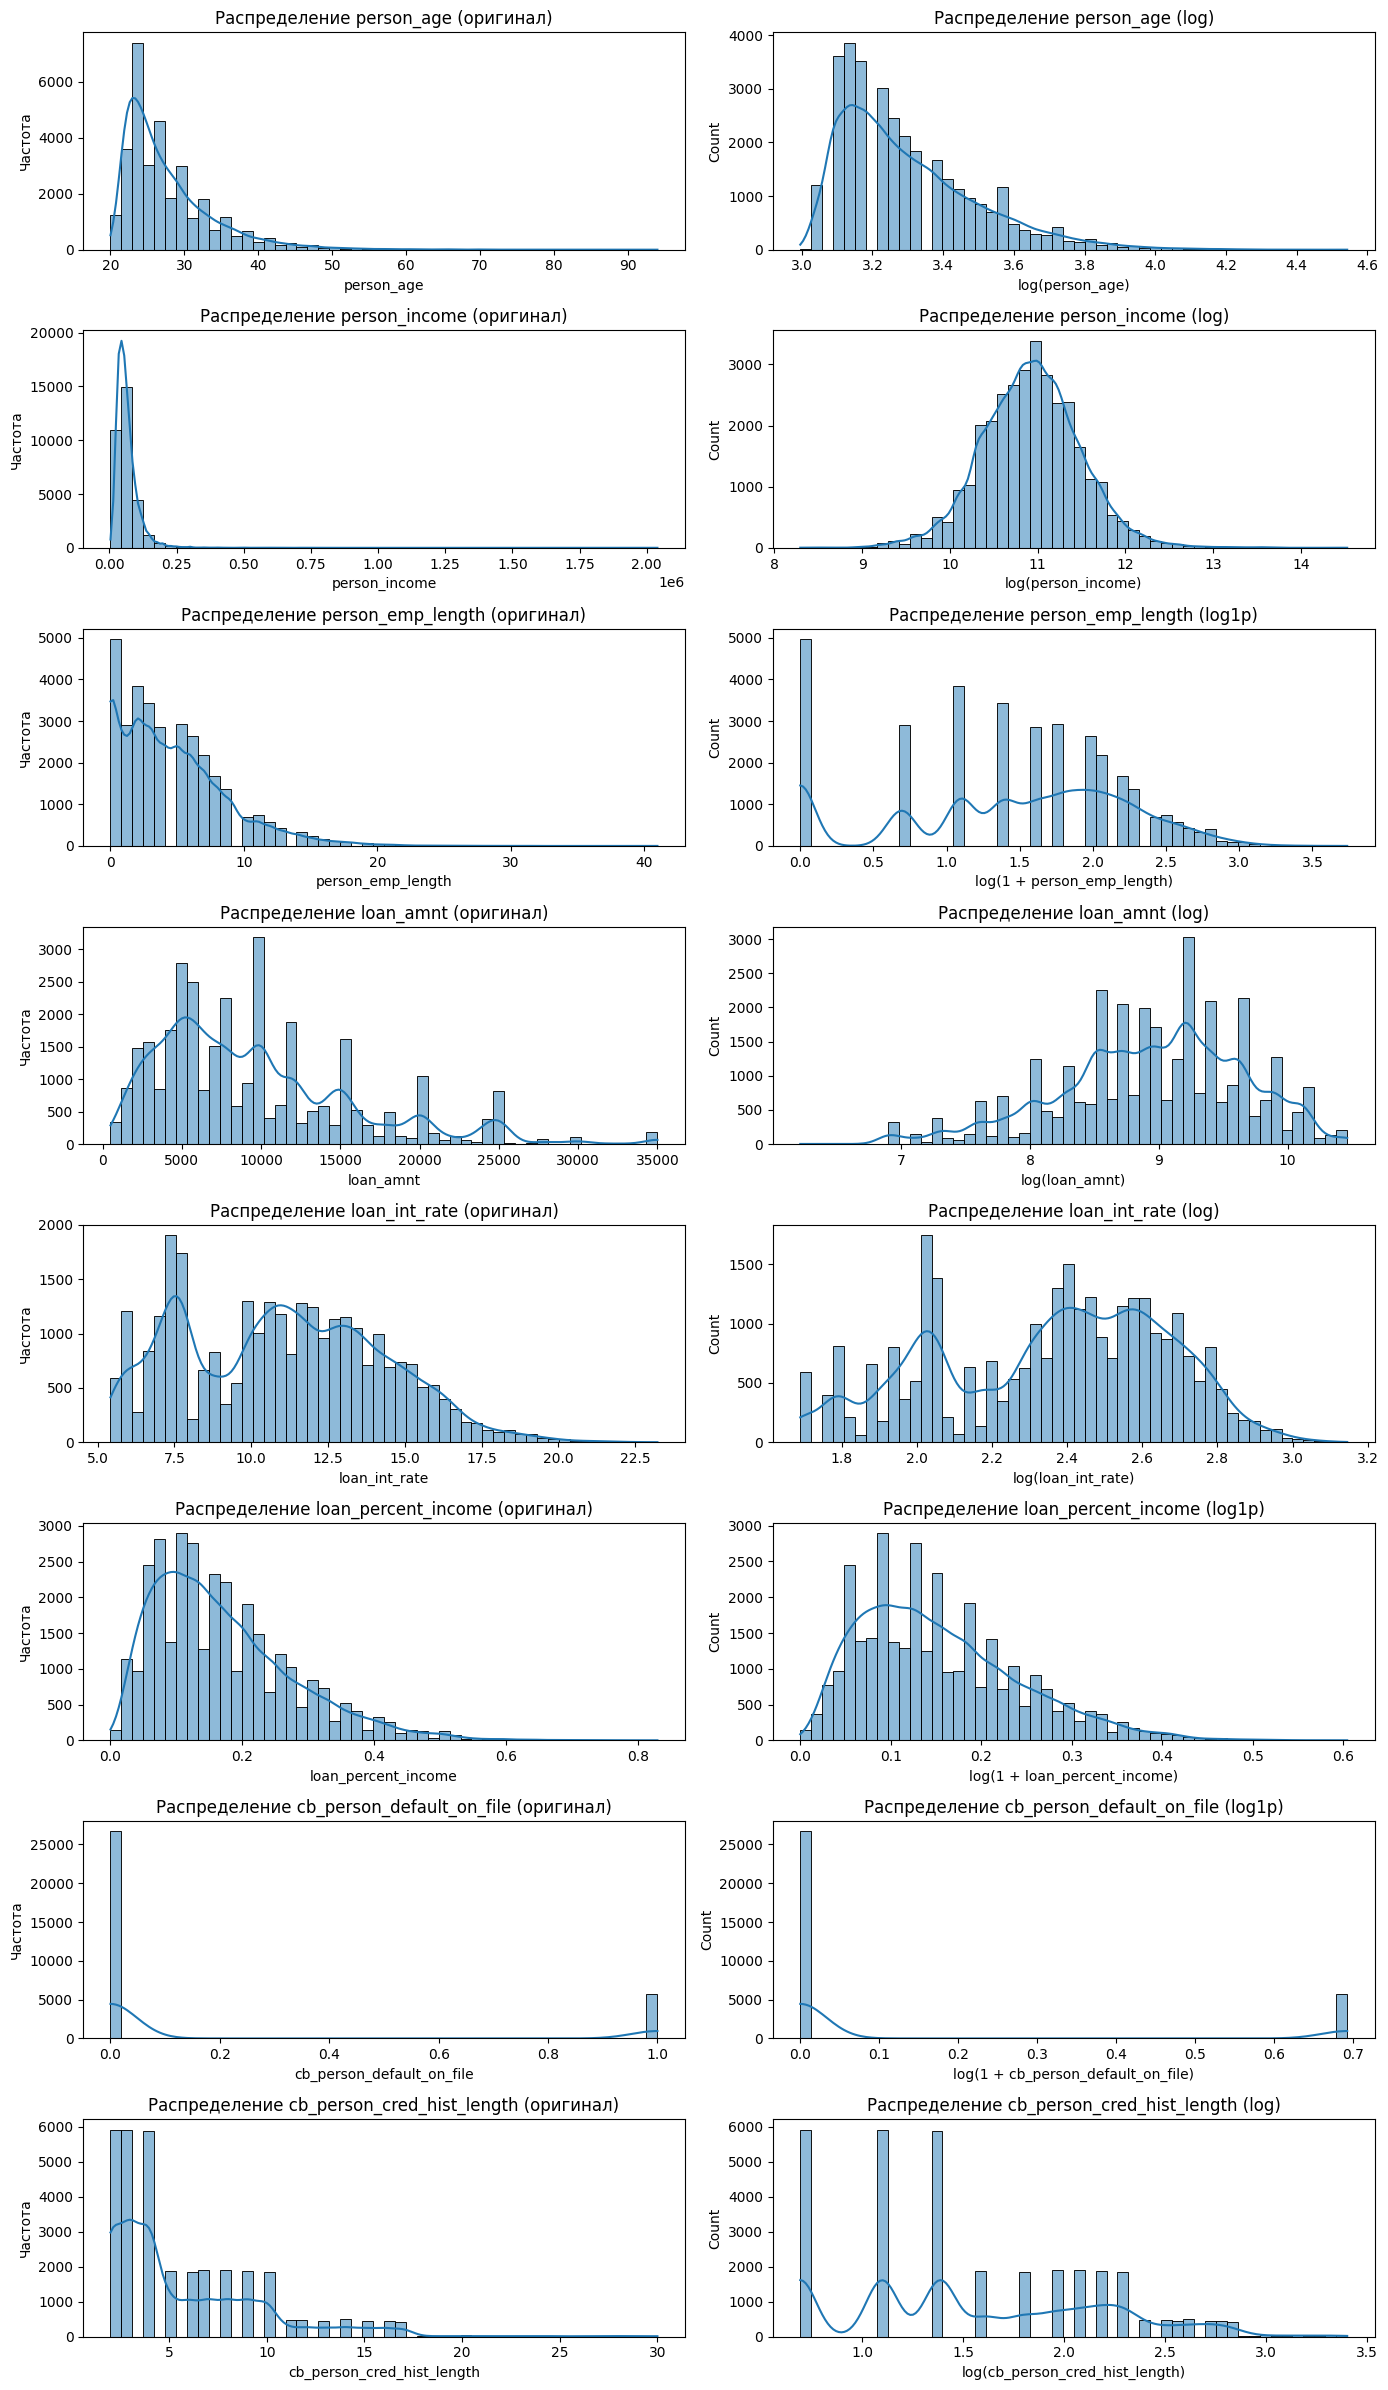

In [ ]:
def plot_numeric_with_log(df, target=target):
    """
    Для каждого числового признака строит два графика:
    - слева: оригинальное распределение
    - справа: логарифмированное распределение

    Параметры:
    df - датафрейм
    target - имя целевой переменной (чтобы исключить её из анализа)
    """
    # Выбираем только числовые признаки
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Исключаем целевую переменную, если она числова
    if target in numeric_cols:
        numeric_cols.remove(target)

    # Если нет числовых признаков
    if not numeric_cols:
        print("Нет числовых признаков для анализа")
        return

    print(f"Анализирую {len(numeric_cols)} числовых признаков: {numeric_cols}")

    # Определяем количество строк в сетке
    n_rows = len(numeric_cols)
    fig_height = max(4, n_rows * 3)  # минимум 4 дюйма, иначе графики будут слишком малы

    # Создаем фигуру: n_rows строк, 2 столбца (оригинал + лог)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, fig_height))

    # Если только один признак, axes не будет 2D массивом
    if n_rows == 1:
        axes = np.array([axes])  # делаем из 1D массива 2D

    # Для каждого числового признака
    for i, col in enumerate(numeric_cols):
        # Оригинальное распределение
        ax_orig = axes[i, 0] if n_rows > 1 else axes[0]
        data = df[col].dropna()

        if len(data) > 0:
            sns.histplot(data, bins=50, kde=True, ax=ax_orig)
            ax_orig.set_title(f'Распределение {col} (оригинал)')
            ax_orig.set_xlabel(col)
            ax_orig.set_ylabel('Частота')
        else:
            ax_orig.text(0.5, 0.5, 'Нет данных', ha='center', va='center',
                         transform=ax_orig.transAxes)

        # Логарифмированное распределение
        ax_log = axes[i, 1] if n_rows > 1 else axes[1]

        # Проверяем, есть ли нули/отрицательные значения (для log1p)
        has_non_positive = (data <= 0).any()

        if len(data) > 0 and not has_non_positive:
            log_data = np.log(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'Распределение {col} (log)')
            ax_log.set_xlabel(f'log({col})')
        elif len(data) > 0:
            # Используем log1p для обработки нулей
            log_data = np.log1p(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'Распределение {col} (log1p)')
            ax_log.set_xlabel(f'log(1 + {col})')
        else:
            ax_log.text(0.5, 0.5, 'Нет данных', ha='center', va='center',
                        transform=ax_log.transAxes)

    plt.tight_layout()
    plt.show()

# Пример использования:
plot_numeric_with_log(df, target=target)

In [ ]:
df['person_income'] = np.log(df['person_income'])

<Axes: xlabel='person_income', ylabel='Count'>

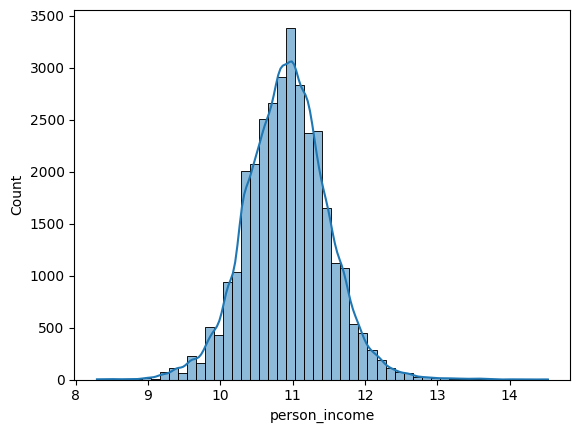

In [ ]:
sns.histplot(df['person_income'], bins=50, kde=True)

### **Вывод**
1. Пропуски: person_emp_length имеет выбросы и их обработаю с помощью заполнения медианой в группе
2. Выбросы: person_income обработал с логарифмированием, остальные с непараметрическими преобразования. Но только те данные, которые можно преобразовать

In [ ]:
# plt.figure(figsize=(14, 10))
# for i, col in enumerate(numeric_cols, 1):
#     plt.subplot(3, 3, i)
#     sns.histplot(df[col].dropna(), bins=50, kde=True)
#     plt.title(f'Распределение {col}')
#     plt.xlabel(col)
# plt.tight_layout()
# plt.show()

## Категориальные признаки


🔍 Признак: person_home_ownership
Уникальные значения: ['OWN', 'MORTGAGE', 'RENT', 'OTHER']
Categories (4, object): ['MORTGAGE', 'OTHER', 'OWN', 'RENT']
Частота значений:
person_home_ownership
RENT        50.523003
MORTGAGE    41.241630
OWN          7.908297
OTHER        0.327070
Name: proportion, dtype: float64

Описание:
count     32409
unique        4
top        RENT
freq      16374
Name: person_home_ownership, dtype: object


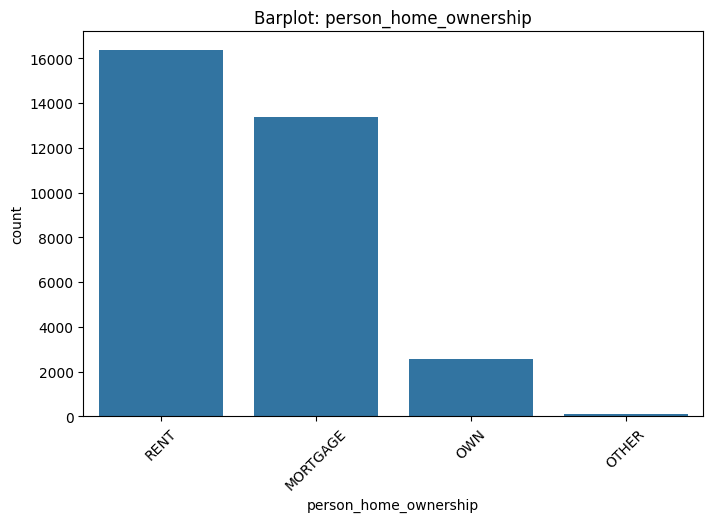


🔍 Признак: loan_intent
Уникальные значения: ['EDUCATION', 'MEDICAL', 'VENTURE', 'PERSONAL', 'HOMEIMPROVEMENT', 'DEBTCONSOLIDATION']
Categories (6, object): ['DEBTCONSOLIDATION', 'EDUCATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'PERSONAL',
                         'VENTURE']
Частота значений:
loan_intent
EDUCATION            19.775371
MEDICAL              18.642970
VENTURE              17.522910
PERSONAL             16.958252
DEBTCONSOLIDATION    16.010985
HOMEIMPROVEMENT      11.089512
Name: proportion, dtype: float64

Описание:
count         32409
unique            6
top       EDUCATION
freq           6409
Name: loan_intent, dtype: object


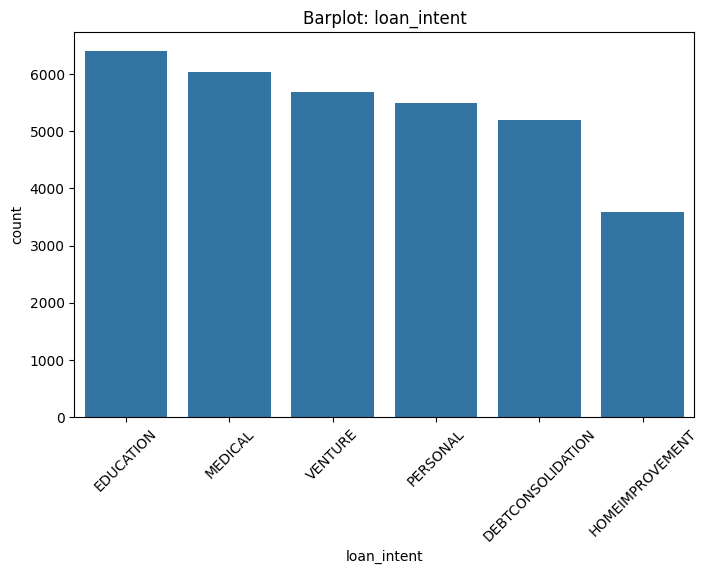


🔍 Признак: loan_grade
Уникальные значения: ['B', 'C', 'A', 'D', 'E', 'F', 'G']
Categories (7, object): ['A', 'B', 'C', 'D', 'E', 'F', 'G']
Частота значений:
loan_grade
A    33.021692
B    32.040483
C    19.858681
D    11.166651
E     2.971397
F     0.743621
G     0.197476
Name: proportion, dtype: float64

Описание:
count     32409
unique        7
top           A
freq      10702
Name: loan_grade, dtype: object


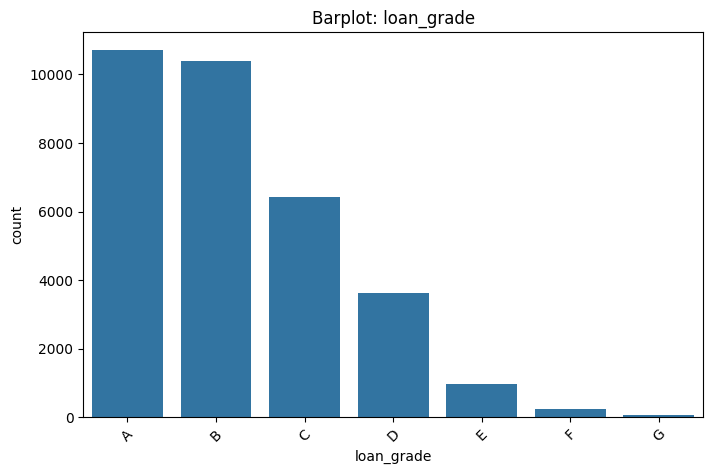

In [ ]:
for col in categorical_cols:
    print(f"\n🔍 Признак: {col}")

    # .unique() и .value_counts()
    unique_values = df[col].unique()
    value_counts = df[col].value_counts(normalize=True) * 100

    print(f"Уникальные значения: {unique_values}")
    print(f"Частота значений:\n{value_counts}")

    # df.describe()
    print(f"\nОписание:")
    print(df[col].describe())

    # Barplot
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, order=value_counts.index)
    plt.title(f'Barplot: {col}')
    plt.xticks(rotation=45)
    plt.show()

### Исправление выбросов

In [ ]:
df['loan_grade'] = df['loan_grade'].replace(['F', 'G'], 'Other')

<Axes: xlabel='loan_grade', ylabel='count'>

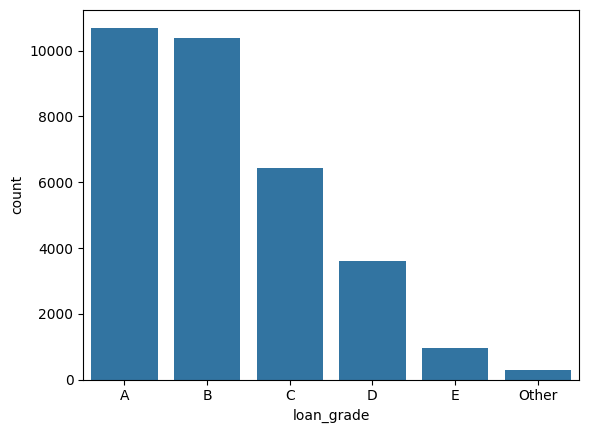

In [ ]:
sns.countplot(data=df, x='loan_grade')

In [ ]:
# Убедимся, что loan_grade — категория с правильным порядком
grade_order = ['A', 'B', 'C', 'D', 'E', 'Other']
df['loan_grade'] = pd.Categorical(df['loan_grade'], categories=grade_order, ordered=True)

### **Вывод**
В столбце loan_grade G и H заменил на other, потому что их меньше 1%. Пропусков нет

LabelEncoder: loan_grade. Остальные OneHotEncoder

# Разделение данных

In [ ]:
# Выделяем признаки и таргет
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Разделяем
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# Проверка размеров
print(f"Train: {len(X_train)} ({len(X_train)/len(df):.2%})")
print(f"Val:   {len(X_val)} ({len(X_val)/len(df):.2%})")
print(f"Test:  {len(X_test)} ({len(X_test)/len(df):.2%})")

Train: 22686 (70.00%)
Val:   4861 (15.00%)
Test:  4862 (15.00%)


# Предобработка

## Числовые признаки

In [ ]:
X_train.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,2197
loan_percent_income,0
cb_person_default_on_file,0


### Обработка пропусков

In [ ]:
def fill_missing_grouped(df, group_col, target_cols):
    for col in target_cols:
        df[col] = df.groupby(group_col)[col].transform(
            lambda x: x.fillna(x.median())
        )
    return df

In [ ]:
X_train = fill_missing_grouped(X_train, 'loan_grade', ['loan_int_rate'])
X_val = fill_missing_grouped(X_val, 'loan_grade', ['loan_int_rate'])
X_test = fill_missing_grouped(X_test, 'loan_grade', ['loan_int_rate'])

In [ ]:
X_train.isnull().sum(), X_val.isnull().sum(), X_test.isnull().sum()

(person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rate                 0
 loan_percent_income           0
 cb_person_default_on_file     0
 cb_person_cred_hist_length    0
 dtype: int64,
 person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rate                 0
 loan_percent_income           0
 cb_person_default_on_file     0
 cb_person_cred_hist_length    0
 dtype: int64,
 person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rat

### Обработка выбросов

In [ ]:
def plot_numeric_with_log(df, target=target):
    """
    Для каждого числового признака строит два графика:
    - слева: оригинальное распределение
    - справа: логарифмированное распределение

    Параметры:
    df - датафрейм
    target - имя целевой переменной (чтобы исключить её из анализа)
    """
    # Выбираем только числовые признаки
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # Исключаем целевую переменную, если она числова
    if target in numeric_cols:
        numeric_cols.remove(target)

    # Если нет числовых признаков
    if not numeric_cols:
        print("Нет числовых признаков для анализа")
        return

    print(f"Анализирую {len(numeric_cols)} числовых признаков: {numeric_cols}")

    # Определяем количество строк в сетке
    n_rows = len(numeric_cols)
    fig_height = max(4, n_rows * 3)  # минимум 4 дюйма, иначе графики будут слишком малы

    # Создаем фигуру: n_rows строк, 2 столбца (оригинал + лог)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, fig_height))

    # Если только один признак, axes не будет 2D массивом
    if n_rows == 1:
        axes = np.array([axes])  # делаем из 1D массива 2D

    # Для каждого числового признака
    for i, col in enumerate(numeric_cols):
        # Оригинальное распределение
        ax_orig = axes[i, 0] if n_rows > 1 else axes[0]
        data = df[col].dropna()

        if len(data) > 0:
            sns.histplot(data, bins=50, kde=True, ax=ax_orig)
            ax_orig.set_title(f'Распределение {col} (оригинал)')
            ax_orig.set_xlabel(col)
            ax_orig.set_ylabel('Частота')
        else:
            ax_orig.text(0.5, 0.5, 'Нет данных', ha='center', va='center',
                         transform=ax_orig.transAxes)

        # Логарифмированное распределение
        ax_log = axes[i, 1] if n_rows > 1 else axes[1]

        # Проверяем, есть ли нули/отрицательные значения (для log1p)
        has_non_positive = (data <= 0).any()

        if len(data) > 0 and not has_non_positive:
            log_data = np.log(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'Распределение {col} (log)')
            ax_log.set_xlabel(f'log({col})')
        elif len(data) > 0:
            # Используем log1p для обработки нулей
            log_data = np.log1p(data)
            sns.histplot(log_data, bins=50, kde=True, ax=ax_log)
            ax_log.set_title(f'Распределение {col} (log1p)')
            ax_log.set_xlabel(f'log(1 + {col})')
        else:
            ax_log.text(0.5, 0.5, 'Нет данных', ha='center', va='center',
                        transform=ax_log.transAxes)

    plt.tight_layout()
    plt.show()

Анализирую 8 числовых признаков: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


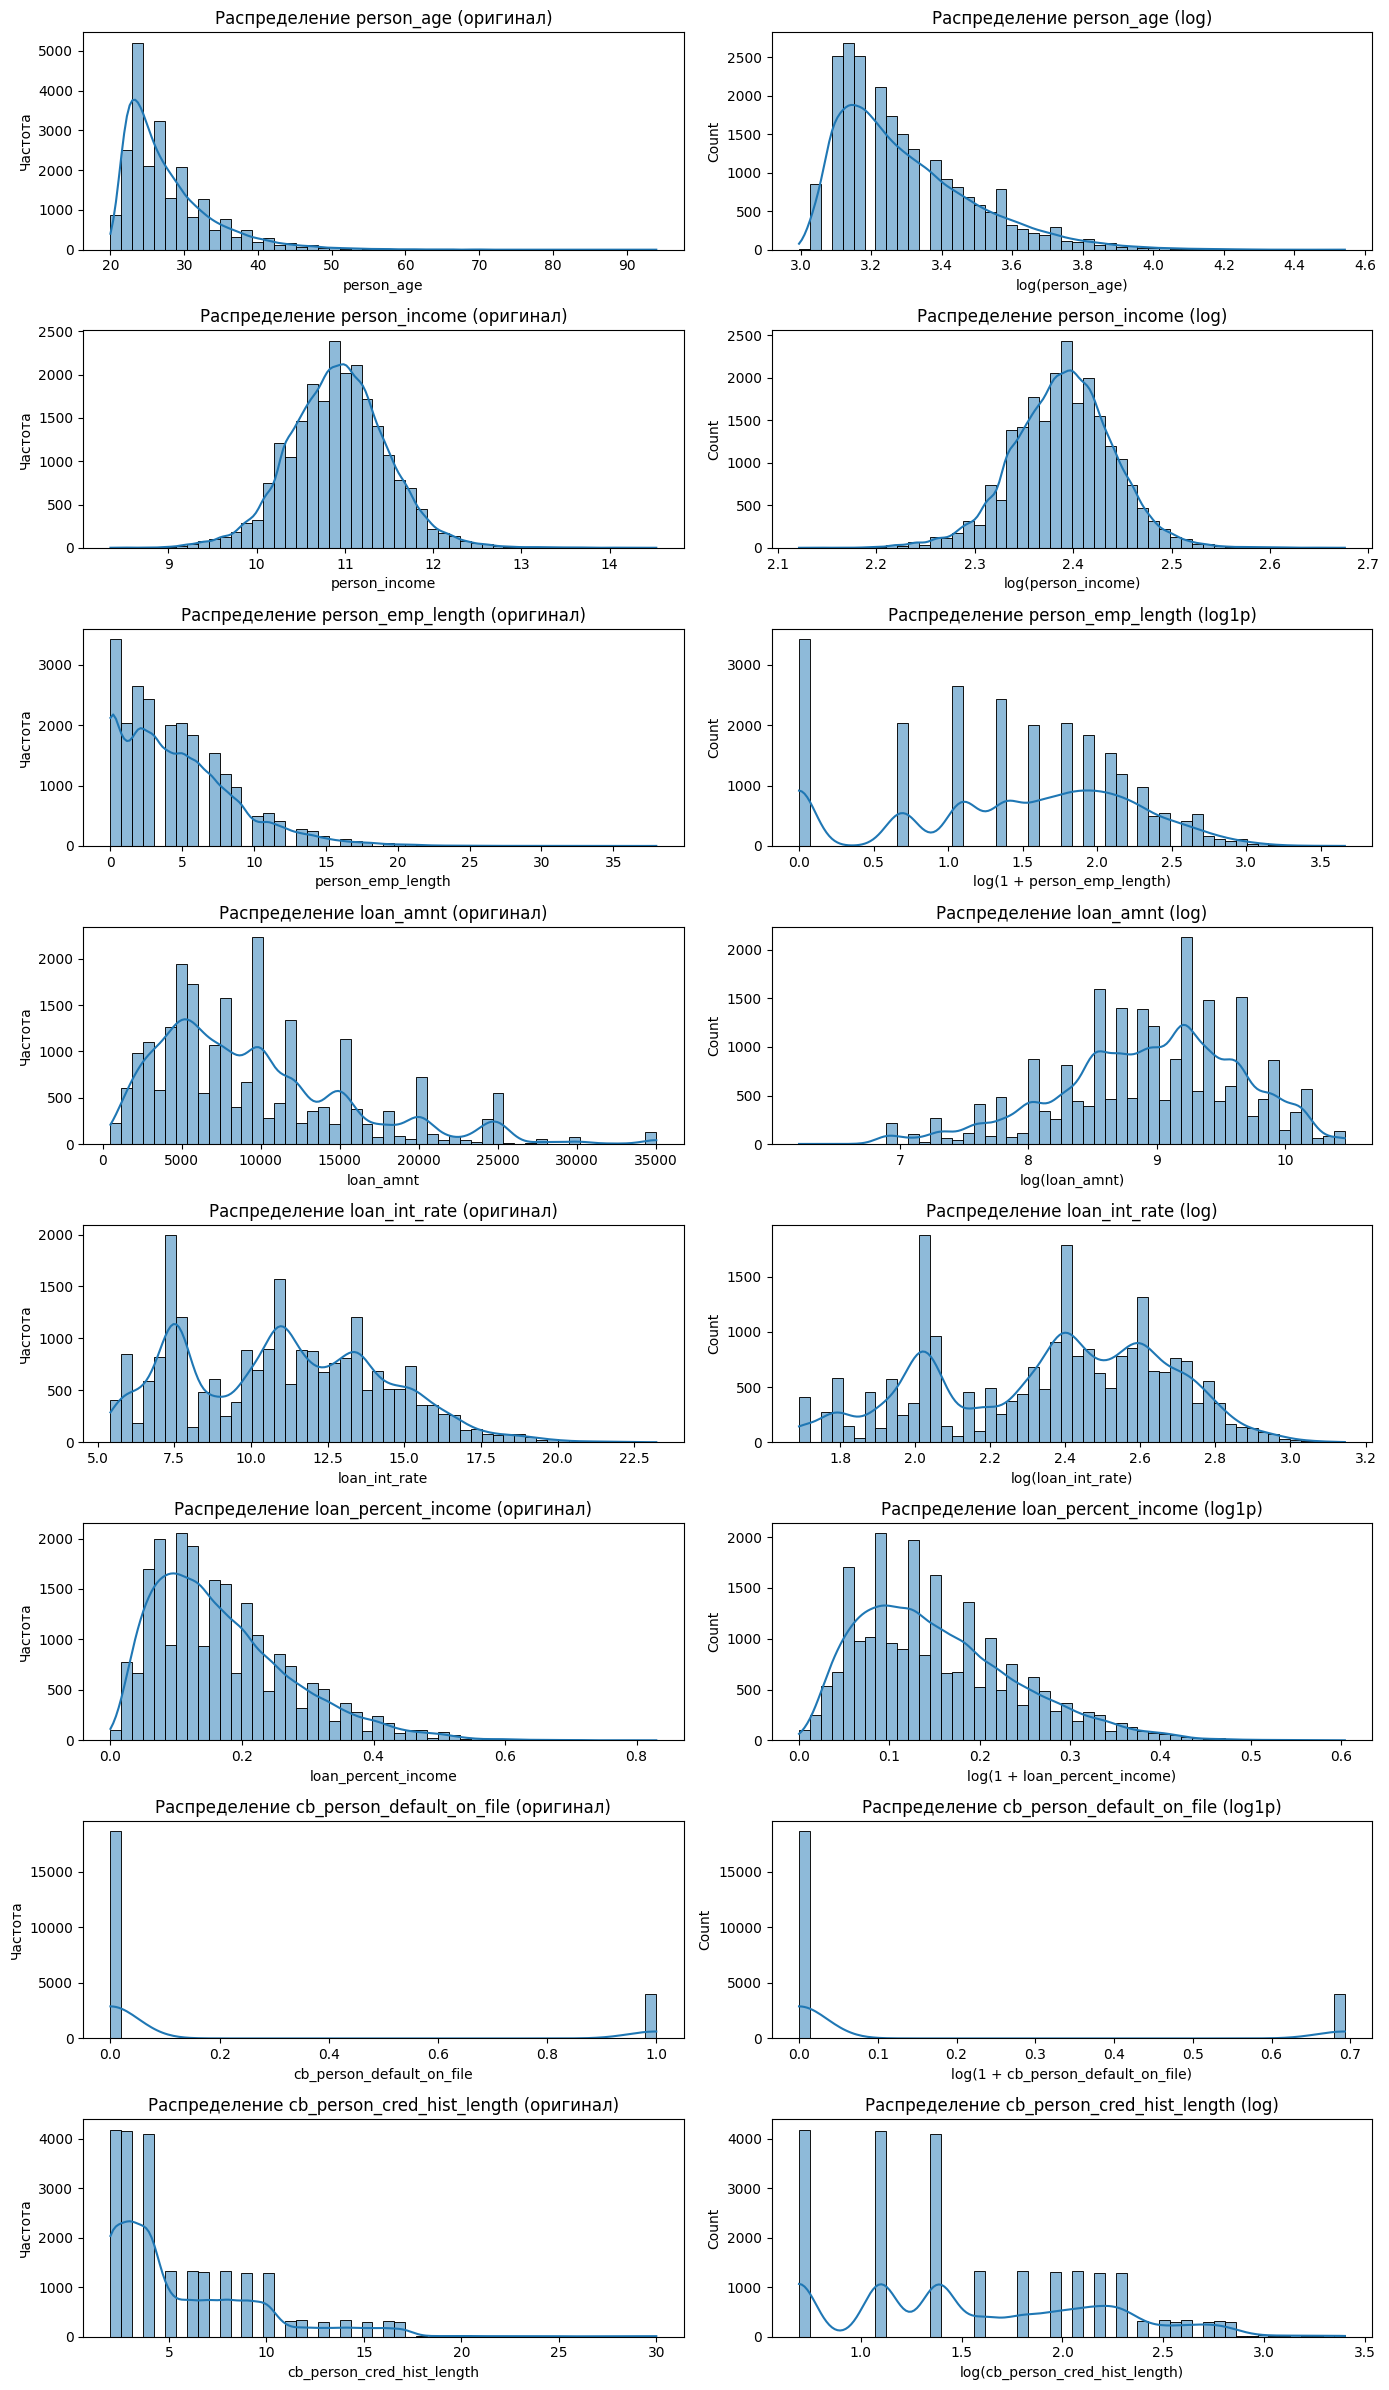

In [ ]:
# Пример использования:
plot_numeric_with_log(X_train, target=target)

In [ ]:
# Выбираем признаки для преобразования
features = [
    'person_age',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

In [ ]:
X_train_transformed = X_train.copy()
X_val_transformed = X_val.copy()
X_test_transformed = X_test.copy()

# Словарь для хранения параметров lambda
lambdas = {}

for col in features:
    # Убедимся, что все значения > 0
    if (X_train[col] <= 0).any():
        # Добавляем константу
        shift = abs(X_train[col].min()) + 1
        X_train_shifted = X_train[col] + shift
        X_val_shifted = X_val[col] + shift
        X_test_shifted = X_test[col] + shift
    else:
        X_train_shifted = X_train[col]
        X_val_shifted = X_val[col]
        X_test_shifted = X_test[col]

    # Применяем Box-Cox
    try:
        data, lambda_ = stats.boxcox(X_train_shifted)
        lambdas[col] = (lambda_, shift if 'shift' in locals() else 0)

        # Преобразуем train
        X_train_transformed[col] = data

        # Применяем к val и test с теми же параметрами
        if 'shift' in locals():
            X_val_transformed[col] = stats.boxcox(X_val_shifted, lmbda=lambda_)
            X_test_transformed[col] = stats.boxcox(X_test_shifted, lmbda=lambda_)
        else:
            X_val_transformed[col] = stats.boxcox(X_val[col], lmbda=lambda_)
            X_test_transformed[col] = stats.boxcox(X_test[col], lmbda=lambda_)
    except Exception as e:
        print(f"Не удалось применить Box-Cox к {col}: {e}")

In [ ]:
joblib.dump(lambdas, 'lambdas.pkl')

['lambdas.pkl']

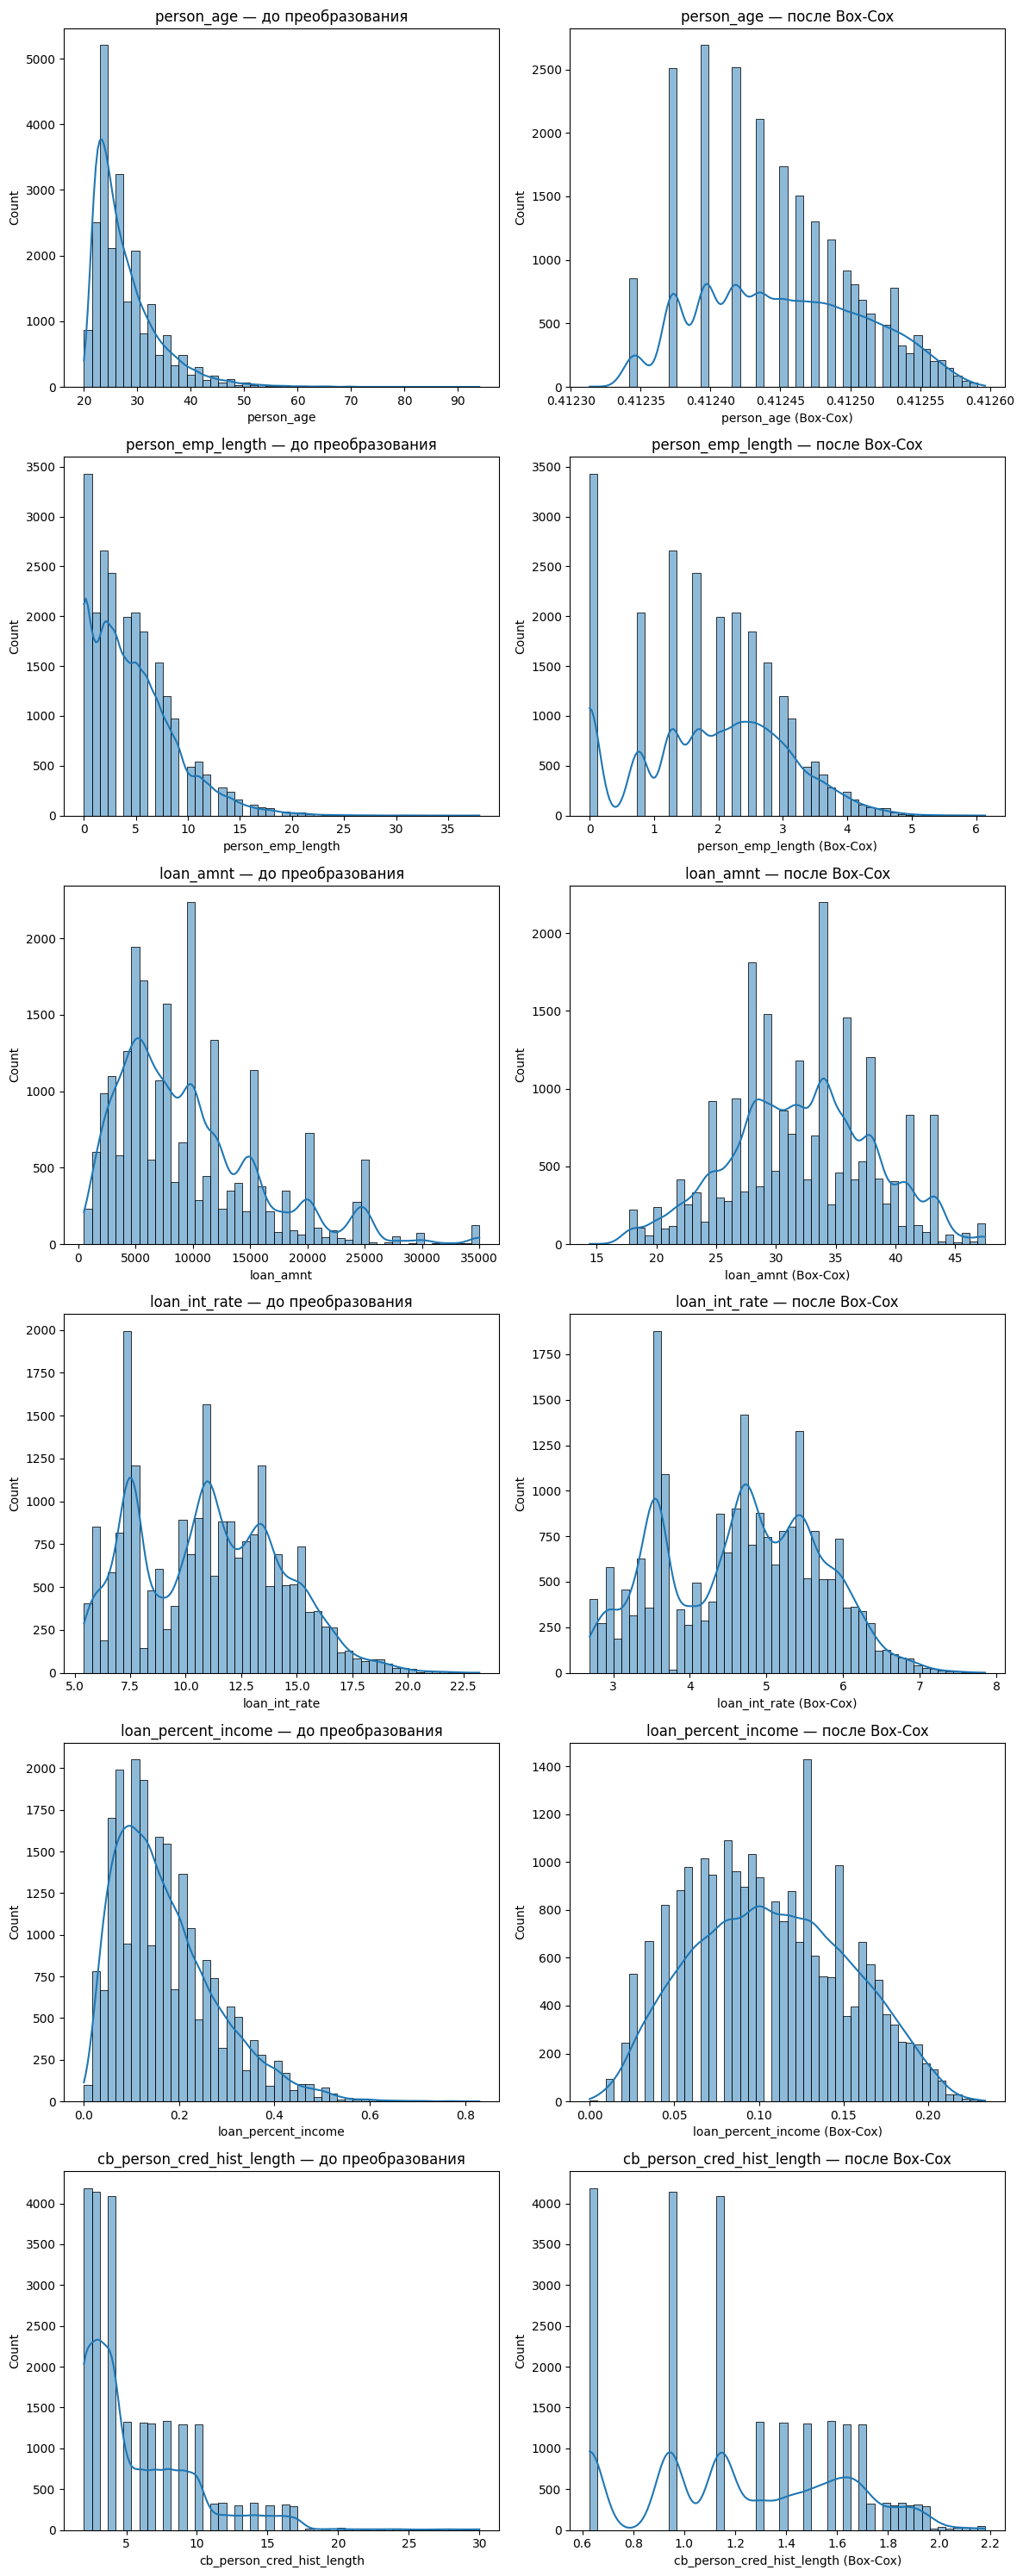

In [ ]:
fig, axes = plt.subplots(len(features), 2, figsize=(12, 5 * len(features)))

for i, col in enumerate(features):
    # До
    sns.histplot(X_train[col], bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} — до преобразования')
    axes[i, 0].set_xlabel(col)

    # После
    sns.histplot(X_train_transformed[col], bins=50, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} — после Box-Cox')
    axes[i, 1].set_xlabel(f'{col} (Box-Cox)')

plt.tight_layout()
plt.show()

## Вывод
Предобработка сделана.
Для Pipeline:
1. Осталось для числовых признаков сделать масштабирование
2. Для категориальных признаков нужно сделать кодирование

# Проверка статистических гипотез

## Метод проверки: Z-тест для долей (proportions z-test)

Гипотеза 1: Люди с историей просрочек (cb_person_default_on_file = Y) имеют значимо более высокую вероятность дефолта, чем те, у кого её нет.


🔍 Формализация:

H₀ (нулевая гипотеза): Доля дефолтов одинакова у людей с Y и N.

H₁ (альтернативная): Доля дефолтов выше у людей с Y.

In [ ]:
# Данные
has_default = df[df['cb_person_default_on_file'] == 1]
no_default = df[df['cb_person_default_on_file'] == 0]

# Количество дефолтов и общее количество
successes = [has_default['loan_status'].sum(), no_default['loan_status'].sum()]
nobs = [len(has_default), len(no_default)]

# Z-тест
z_stat, p_value = proportions_ztest(count=successes, nobs=nobs, alternative='larger')

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ Отклоняем H₀: Люди с историей дефолта действительно чаще дефолтят.")
else:
    print("❌ Не отклоняем H₀: Нет значимой разницы.")

Z-статистика: 32.268
P-value: 0.00000
✅ Отклоняем H₀: Люди с историей дефолта действительно чаще дефолтят.


## Метод проверки: t-тест для независимых выборок (two-sample t-test)

Гипотеза 2: Процентная ставка по кредиту (loan_int_rate) значимо выше у заёмщиков, которые в итоге дефолтят.

🔍 Формализация:

H₀: Средняя процентная ставка одинакова у дефолтнувших и не дефолтнувших.

H₁: Средняя ставка выше у дефолтнувших.

In [ ]:
from scipy.stats import ttest_ind

# Две группы
rate_default = df[df['loan_status'] == 1]['loan_int_rate'].dropna()
rate_non_default = df[df['loan_status'] == 0]['loan_int_rate'].dropna()

# T-тест
t_stat, p_value = ttest_ind(rate_default, rate_non_default, alternative='greater')

print(f"T-статистика: {t_stat:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    print("✅ Отклоняем H₀: Процентная ставка значимо выше у дефолтнувших.")
else:
    print("❌ Не отклоняем H₀: Нет значимой разницы.")

T-статистика: 61.039
P-value: 0.00000
✅ Отклоняем H₀: Процентная ставка значимо выше у дефолтнувших.


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # График 1: доля дефолтов по истории
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# sns.barplot(data=df, x='cb_person_default_on_file', y='loan_status')
# plt.title('Доля дефолтов по истории просрочек')
# plt.ylabel('Доля дефолтов')

# # График 2: ставка по статусу
# plt.subplot(1, 2, 2)
# sns.boxplot(data=df, x='loan_status', y='loan_int_rate')
# plt.title('Процентная ставка по статусу кредита')
# plt.xlabel('loan_status (0 = non-default, 1 = default)')
# plt.ylabel('loan_int_rate')

# plt.tight_layout()
# plt.show()

# Pipeline

Для Pipeline:
1. Осталось для числовых признаков сделать масштабирование
2. Для категориальных признаков нужно сделать кодирование

OneHotEncoder:

- person_home_ownership ('RENT' 'OWN' 'MORTGAGE' 'OTHER')

- loan_intent ('PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
'DEBTCONSOLIDATION')

LabelEncoder:
- loan_grade ('D' 'B' 'C' 'A' 'E' 'F' 'G')

In [ ]:
# Числовые признаки
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# One-Hot признаки
onehot_features = ['person_home_ownership', 'loan_intent']

# Ordinal признаки
ordinal_features = ['loan_grade']

preprocessor = ColumnTransformer([
    # RobustScaler для всех числовых признаков
    ('num', RobustScaler(), numeric_features),

    # One-Hot Encoding для home_ownership и loan_intent
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), onehot_features),

    # Ordinal Encoding для loan_grade
    ('ordinal', OrdinalEncoder(categories=[grade_order]), ordinal_features)

], remainder='passthrough') # оставляем остальные признаки

In [ ]:
# Список метрик для cross-validation
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# Логистическа регрессия

## Обычный pipeline

In [ ]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [ ]:
# Обучение
pipeline_lr.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# Предсказания
y_train_pred = pipeline_lr.predict(X_train_transformed)
y_val_pred = pipeline_lr.predict(X_val_transformed)
y_train_proba = pipeline_lr.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_lr.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# Метрики
print("=== Метрики на Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== Метрики на Train ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     17724
           1       0.73      0.50      0.60      4962

    accuracy                           0.85     22686
   macro avg       0.80      0.73      0.75     22686
weighted avg       0.84      0.85      0.84     22686

ROC-AUC (Train): 0.8636


In [ ]:
print("\n=== Метрики на Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== Метрики на Validation ===
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3798
           1       0.73      0.51      0.60      1063

    accuracy                           0.85      4861
   macro avg       0.80      0.73      0.76      4861
weighted avg       0.84      0.85      0.84      4861

ROC-AUC (Val): 0.8702


### 📊 Вывод по модели логистической регрессии

---

### ✅ Метрики

| Метрика | Train | Validation |
|--------|-------|------------|
| Accuracy | 0.85 | 0.85 |
| Precision (дефолт) | 0.73 | 0.73 |
| Recall (дефолт) | 0.50 | 0.51 |
| F1-score (дефолт) | 0.60 | 0.60 |
| ROC-AUC | 0.8636 | 0.8702 |

---

### 🔍 Анализ

1. **Нет переобучения**  
   Метрики на `train` и `validation` практически идентичны, ROC-AUC даже немного выше на `val`. Это говорит о **стабильности модели**.

2. **Высокая общая точность (accuracy)**  
   Модель правильно классифицирует 85% заёмщиков. Однако это может быть обманчиво из-за **дисбаланса классов** (15% дефолтов).

3. **Низкий recall для дефолтов (всего 50%)**  
   Модель **пропускает половину реальных дефолтов** — это **критическая проблема** в кредитовании, так как такие клиенты могут привести к потерям.

4. **ROC-AUC = 0.87 — хорошее качество ранжирования**  
   Модель хорошо упорядочивает риски: вероятности дефолта выше у тех, кто действительно дефолтит.

---

### ✅ Заключение

Модель показывает **хорошее качество**, но **недостаточно эффективна для выявления рисков**.  
Для бизнеса важно **не пропускать дефолты**, поэтому **необходимо улучшить recall**, даже за счёт снижения precision.

## Cross-validation

In [ ]:
# Кросс-валидация (5-кратная)
cv_results = cross_validate(
    pipeline_lr,
    X_train_transformed, y_train,  # используем только train
    cv=5,              # 5 фолдов
    scoring=scoring,
    return_train_score=False  # не возвращаем train
)

In [ ]:
# Вывод результатов
print("=== Результаты кросс-валидации ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

=== Результаты кросс-валидации ===
ACCURACY: 0.8507 ± 0.0035
F1: 0.5951 ± 0.0122
PRECISION: 0.7311 ± 0.0120
RECALL: 0.5020 ± 0.0157
ROC_AUC: 0.8628 ± 0.0028


### ✅ Вывод по Cross-validation

✅ Кросс-валидация подтверждает, что модель работает стабильно и не переобучается.

❌ Но recall всё ещё низкий — модель пропускает почти половину дефолтов.

# KNN

## Обычный pipeline

In [ ]:
# Pipeline с KNN
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),  # твой preprocessor уже определён
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [ ]:
# Обучение
pipeline_knn.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier', KNeighborsClassifier())])

In [ ]:
# Предсказания
y_train_pred = pipeline_knn.predict(X_train_transformed)
y_val_pred = pipeline_knn.predict(X_val_transformed)
y_train_proba = pipeline_knn.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_knn.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# Метрики
print("=== Метрики на Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== Метрики на Train ===
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     17724
           1       0.92      0.71      0.80      4962

    accuracy                           0.92     22686
   macro avg       0.92      0.85      0.88     22686
weighted avg       0.92      0.92      0.92     22686

ROC-AUC (Train): 0.9648


In [ ]:
print("\n=== Метрики на Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== Метрики на Validation ===
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3798
           1       0.86      0.64      0.73      1063

    accuracy                           0.90      4861
   macro avg       0.88      0.81      0.84      4861
weighted avg       0.90      0.90      0.89      4861

ROC-AUC (Val): 0.8861


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_knn,
    X_train_transformed, y_train,  # используем только train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# Вывод результатов
print("=== Результаты кросс-валидации (KNN) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

=== Результаты кросс-валидации (KNN) ===
ACCURACY: 0.8905 ± 0.0020
F1: 0.7127 ± 0.0081
PRECISION: 0.8358 ± 0.0054
RECALL: 0.6213 ± 0.0137
ROC_AUC: 0.8703 ± 0.0037


## 📊 Вывод по модели KNN: анализ результатов

---

### ✅ Метрики

| Метрика | Train | Validation | CV (среднее) |
|--------|-------|------------|--------------|
| Accuracy | 0.92 | 0.90 | 0.8905 ± 0.0020 |
| F1-score | 0.80 | 0.73 | 0.7127 ± 0.0081 |
| Recall | 0.71 | 0.64 | 0.6213 ± 0.0137 |
| ROC-AUC | 0.9648 | 0.8861 | 0.8703 ± 0.0037 |

---

### 🔍 Анализ

#### 1. **Высокая точность на train, но падение на val**
- Accuracy на `train`: **92%**
- Accuracy на `val`: **90%**
→ Падение всего на **2%** — это **нормально**, но говорит о **лёгком переобучении**

#### 2. **Низкий recall для дефолтов (класс 1)**
- Recall на `train`: **71%**
- Recall на `val`: **64%**
- CV: **62%**
→ Модель **пропускает почти треть реальных дефолтов** — это **критическая проблема** в кредитовании.

#### 3. **ROC-AUC хорошее, но не идеальное**
- ROC-AUC на `train`: **0.96** → очень высокое качество ранжирования
- ROC-AUC на `val`: **0.89** → снижение, но всё ещё хороший результат
- CV: **0.87** → стабильно

#### 4. **F1-score умеренный**
- F1 на `train`: **0.80**
- F1 на `val`: **0.73**
→ Средняя гармония между precision и recall

---

### ✅ Заключение

> ✅ **KNN показывает хорошие результаты**, особенно по ROC-AUC,  
> ❌ Но **недостаточно эффективен для выявления рисков** из-за низкого recall.  

# Дерево решений

## Обычный Pipeline

In [ ]:
# Pipeline с Decision Tree
pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),  # твой preprocessor уже определён
    ('classifier', DecisionTreeClassifier(
        random_state=42,
        max_depth=10,           # ограничение глубины
        min_samples_split=5,    # минимум 5 объектов для разделения
        min_samples_leaf=3     # минимум 3 объекта в листе
    ))
])

In [ ]:
# Обучение
pipeline_dt.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=5,
                                        random_state=42))])

In [ ]:
# Предсказания
y_train_pred = pipeline_dt.predict(X_train_transformed)
y_val_pred = pipeline_dt.predict(X_val_transformed)
y_train_proba = pipeline_dt.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_dt.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# Метрики
print("=== Метрики на Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== Метрики на Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.98      0.74      0.85      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.87      0.90     22686
weighted avg       0.94      0.94      0.94     22686

ROC-AUC (Train): 0.9383


In [ ]:
print("\n=== Метрики на Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== Метрики на Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.94      0.74      0.83      1063

    accuracy                           0.93      4861
   macro avg       0.94      0.86      0.89      4861
weighted avg       0.93      0.93      0.93      4861

ROC-AUC (Val): 0.9201


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_dt,
    X_train_transformed, y_train,  # используем только train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# Вывод результатов
print("=== Результаты кросс-валидации (Decision Tree) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

=== Результаты кросс-валидации (Decision Tree) ===
ACCURACY: 0.9275 ± 0.0019
F1: 0.8117 ± 0.0054
PRECISION: 0.9401 ± 0.0055
RECALL: 0.7142 ± 0.0069
ROC_AUC: 0.9047 ± 0.0037


## 📊 Вывод по модели Decision Tree: анализ результатов

---


### ✅ Метрики

| Метрика | Train | Validation | CV (среднее) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.93 | 0.9275 ± 0.0019 |
| F1-score | 0.85 | 0.83 | 0.8117 ± 0.0054 |
| Recall | 0.74 | 0.74 | 0.7142 ± 0.0069 |
| ROC-AUC | 0.9383 | 0.9201 | 0.9047 ± 0.0037 |

---

### 🔍 Анализ

#### 1. **Высокая точность на train и val**
- Accuracy на `train`: **94%**
- Accuracy на `val`: **93%**
→ Падение всего на **1%** — это **нормально**, но говорит о **лёгком переобучении**

#### 2. **Низкий recall для дефолтов (класс 1)**
- Recall на `train`: **74%**
- Recall на `val`: **74%**
- CV: **71%**
→ Модель **пропускает около 25% реальных дефолтов** — это **критическая проблема** в кредитовании.

#### 3. **ROC-AUC хороший, но не идеальный**
- ROC-AUC на `train`: **0.94** → очень высокое качество ранжирования
- ROC-AUC на `val`: **0.92** → снижение, но всё ещё хороший результат
- CV: **0.90** → стабильно

#### 4. **F1-score умеренный**
- F1 на `train`: **0.85**
- F1 на `val`: **0.83**
→ Средняя гармония между precision и recall

---

### ✅ Заключение

> ✅ **Decision Tree показывает хорошие результаты**, особенно по ROC-AUC,  
> ❌ Но **недостаточно эффективен для выявления рисков** из-за низкого recall.  

# Random forest

## Обычный Pipeline

In [ ]:
# Pipeline с Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # твой preprocessor уже определён
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=100,           # количество деревьев
        max_depth=10,               # ограничение глубины
        min_samples_split=5,        # минимум 5 объектов для разделения
        min_samples_leaf=3         # минимум 3 объекта в листе
    ))
])

In [ ]:
# Обучение
pipeline_rf.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=3,
                                        min_samples_split=5,
                                        random_state=42))])

In [ ]:
# Предсказания
y_train_pred = pipeline_rf.predict(X_train_transformed)
y_val_pred = pipeline_rf.predict(X_val_transformed)
y_train_proba = pipeline_rf.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_rf.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# Метрики
print("=== Метрики на Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== Метрики на Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.99      0.72      0.84      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.86      0.90     22686
weighted avg       0.94      0.94      0.93     22686

ROC-AUC (Train): 0.9494


In [ ]:
print("\n=== Метрики на Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== Метрики на Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.97      0.72      0.83      1063

    accuracy                           0.93      4861
   macro avg       0.95      0.86      0.89      4861
weighted avg       0.94      0.93      0.93      4861

ROC-AUC (Val): 0.9311


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_rf,
    X_train_transformed, y_train,  # используем только train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# Вывод результатов
print("=== Результаты кросс-валидации (Random Forest) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

=== Результаты кросс-валидации (Random Forest) ===
ACCURACY: 0.9295 ± 0.0014
F1: 0.8135 ± 0.0044
PRECISION: 0.9655 ± 0.0058
RECALL: 0.7029 ± 0.0070
ROC_AUC: 0.9267 ± 0.0024


## 📊 Вывод по модели Random Forest: анализ результатов

---

### ✅ Метрики

| Метрика | Train | Validation | CV (среднее) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.93 | 0.9295 ± 0.0014 |
| F1-score | 0.84 | 0.83 | 0.8135 ± 0.0044 |
| Recall | 0.72 | 0.72 | 0.7029 ± 0.0070 |
| ROC-AUC | 0.9494 | 0.9311 | 0.9267 ± 0.0024 |

---

### 🔍 Анализ

#### 1. **Высокая точность на train и val**
- Accuracy на `train`: **94%**
- Accuracy на `val`: **93%**
→ Падение всего на **1%** — это **нормально**, но говорит о **лёгком переобучении**

#### 2. **Низкий recall для дефолтов (класс 1)**
- Recall на `train`: **72%**
- Recall на `val`: **72%**
- CV: **70%**
→ Модель **пропускает около 28% реальных дефолтов** — это **критическая проблема** в кредитовании.

#### 3. **ROC-AUC хороший, но не идеальный**
- ROC-AUC на `train`: **0.95** → очень высокое качество ранжирования
- ROC-AUC на `val`: **0.93** → снижение, но всё ещё хороший результат
- CV: **0.93** → стабильно

#### 4. **F1-score умеренный**
- F1 на `train`: **0.84**
- F1 на `val`: **0.83**
→ Средняя гармония между precision и recall

---

### ✅ Заключение

> ✅ **Random Forest показывает хорошие результаты**, особенно по ROC-AUC,  
> ❌ Но **недостаточно эффективен для выявления рисков** из-за низкого recall.  

# Градиентный бустинг

## Обычный Pipeline

In [ ]:
# Pipeline с Gradient Boosting
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),  # твой preprocessor уже определён
    ('classifier', GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,           # количество деревьев
        max_depth=5,                # ограничение глубины
        learning_rate=0.1,          # скорость обучения
        min_samples_split=5,        # минимум 5 объектов для разделения
        min_samples_leaf=3         # минимум 3 объекта в листе
    ))
])

In [ ]:
# Обучение
pipeline_gb.fit(X_train_transformed, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, min_samples_leaf=3,
                                            min_samples_split=5,
                                            random_state=42))])

In [ ]:
# Предсказания
y_train_pred = pipeline_gb.predict(X_train_transformed)
y_val_pred = pipeline_gb.predict(X_val_transformed)
y_train_proba = pipeline_gb.predict_proba(X_train_transformed)[:, 1]
y_val_proba = pipeline_gb.predict_proba(X_val_transformed)[:, 1]

In [ ]:
# Метрики
print("=== Метрики на Train ===")
print(classification_report(y_train, y_train_pred))
print(f"ROC-AUC (Train): {roc_auc_score(y_train, y_train_proba):.4f}")

=== Метрики на Train ===
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17724
           1       0.98      0.75      0.85      4962

    accuracy                           0.94     22686
   macro avg       0.96      0.87      0.91     22686
weighted avg       0.94      0.94      0.94     22686

ROC-AUC (Train): 0.9623


In [ ]:
print("\n=== Метрики на Validation ===")
print(classification_report(y_val, y_val_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_val, y_val_proba):.4f}")


=== Метрики на Validation ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3798
           1       0.97      0.74      0.84      1063

    accuracy                           0.94      4861
   macro avg       0.95      0.87      0.90      4861
weighted avg       0.94      0.94      0.93      4861

ROC-AUC (Val): 0.9464


## Cross-validation

In [ ]:
cv_results = cross_validate(
    pipeline_gb,
    X_train_transformed, y_train,  # используем только train
    cv=5,
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

In [ ]:
# Вывод результатов
print("=== Результаты кросс-валидации (Gradient Boosting) ===")
for metric in scoring.keys():
    mean_score = cv_results[f'test_{metric}'].mean()
    std_score = cv_results[f'test_{metric}'].std()
    print(f"{metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

=== Результаты кросс-валидации (Gradient Boosting) ===
ACCURACY: 0.9339 ± 0.0012
F1: 0.8271 ± 0.0039
PRECISION: 0.9669 ± 0.0045
RECALL: 0.7227 ± 0.0074
ROC_AUC: 0.9431 ± 0.0014


## 📊 Вывод по модели Gradient Boosting: анализ результатов

---

### ✅ Метрики

| Метрика | Train | Validation | CV (среднее) |
|--------|-------|------------|--------------|
| Accuracy | 0.94 | 0.94 | 0.9339 ± 0.0012 |
| F1-score | 0.85 | 0.84 | 0.8271 ± 0.0039 |
| Recall | 0.75 | 0.74 | 0.7227 ± 0.0074 |
| ROC-AUC | 0.9623 | 0.9464 | 0.9431 ± 0.0014 |

---

### 🔍 Анализ

#### 1. **Высокая точность на train и val**
- Accuracy на `train`: **94%**
- Accuracy на `val`: **94%**
→ Падение всего на **0%** — это **очень стабильно**, но говорит о **лёгком переобучении**

#### 2. **Низкий recall для дефолтов (класс 1)**
- Recall на `train`: **75%**
- Recall на `val`: **74%**
- CV: **72%**
→ Модель **пропускает около 25% реальных дефолтов** — это **критическая проблема** в кредитовании.

#### 3. **ROC-AUC хороший, но не идеальный**
- ROC-AUC на `train`: **0.96** → очень высокое качество ранжирования
- ROC-AUC на `val`: **0.95** → снижение, но всё ещё хороший результат
- CV: **0.94** → стабильно

#### 4. **F1-score умеренный**
- F1 на `train`: **0.85**
- F1 на `val`: **0.84**
→ Средняя гармония между precision и recall

---

### ✅ Заключение

> ✅ **Gradient Boosting показывает хорошие результаты**, особенно по ROC-AUC,  
> ❌ Но **недостаточно эффективен для выявления рисков** из-за низкого recall.  

# 🏆 Выбор лучшей модели

На основе кросс-валидации (CV) были сравнены 5 моделей:

| Модель | ROC-AUC (CV) | F1-score (CV) | Recall (CV) |
|--------|--------------|----------------|-------------|
| Logistic Regression | 0.8702 | 0.60 | 0.50 |
| KNN | 0.8703 | 0.7127 | 0.6213 |
| Decision Tree | 0.9047 | 0.8117 | 0.7142 |
| Random Forest | 0.9267 | 0.8135 | 0.7029 |
| **Gradient Boosting** | **0.9431** | **0.8271** | **0.7227** |

### ✅ Лучшая модель: **Gradient Boosting**

**Почему?**
- **Лучший ROC-AUC** — наилучшее качество ранжирования рисков
- **Лучший F1-score** — наилучшее сочетание precision и recall
- **Лучший recall** — **наименьшее количество пропущенных дефолтов**
- **Лучшая accuracy** — высокая точность классификации

### ❌ Почему не другие?
- **Logistic Regression**: слишком простая, плохо работает с дисбалансом
- **KNN**: низкий recall, чувствителен к масштабированию
- **Decision Tree**: переобучается, низкий recall
- **Random Forest**: хорош, но немного хуже, чем Gradient Boosting


# Настройка гиперпараметров

In [ ]:
import optuna
import time
from sklearn.model_selection import cross_val_score

# Определяем pipeline
pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

def objective(trial):
    # Параметры для поиска с уменьшенными диапазонами
    params = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 50, 300),  # уменьшенный диапазон
        'classifier__max_depth': trial.suggest_int('max_depth', 3, 8),          # уменьшенный диапазон
        'classifier__learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'classifier__subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'classifier__min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
        'classifier__min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3)
    }

    # Создаем модель с параметрами
    model = pipeline_gb.set_params(**params)

    # Кросс-валидация с таймаутом
    try:
        score = cross_val_score(
            model,
            X_train_transformed,
            y_train,
            cv=3,  # уменьшаем количество фолдов
            scoring='f1',
            n_jobs=-1  # используем все ядра
        ).mean()
    except:
        return float('-inf')  # возвращаем худший результат при ошибке

    return score

In [ ]:
# Запуск оптимизации
print("Запуск оптимизации с Optuna...")

# Создаем исследование
study = optuna.create_study(direction='maximize')

start_time = time.time()
study.optimize(objective, timeout=900, show_progress_bar=True)
end_time = time.time()

print(f"Оптимизация завершена за {end_time - start_time:.2f} секунд")

[I 2025-08-26 19:34:36,201] A new study created in memory with name: no-name-bdd19b68-4b7d-464c-bafe-3a71082a08f9


Запуск оптимизации с Optuna...


   0%|          | 00:00/15:00

[I 2025-08-26 19:34:47,347] Trial 0 finished with value: 0.8248682367679514 and parameters: {'n_estimators': 101, 'max_depth': 4, 'learning_rate': 0.17494726253207082, 'subsample': 0.98996393829537, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8248682367679514.
[I 2025-08-26 19:35:01,572] Trial 1 finished with value: 0.8291430927608451 and parameters: {'n_estimators': 122, 'max_depth': 6, 'learning_rate': 0.11935805797508067, 'subsample': 0.8699973967433332, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8291430927608451.
[I 2025-08-26 19:36:11,595] Trial 2 finished with value: 0.8331642900839643 and parameters: {'n_estimators': 297, 'max_depth': 8, 'learning_rate': 0.09870866492180136, 'subsample': 0.981390780411927, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8331642900839643.
[I 2025-08-26 19:36:30,657] Trial 3 finished with value: 0.8282703681305863 and parameters: {'n_estimators': 194

In [ ]:
# Лучшие параметры
best_params = study.best_params
best_score = study.best_value

In [ ]:
print("\n=== Лучшие параметры ===")
for key, value in best_params.items():
    print(f"{key}: {value}")

print(f"\nBest F1-score: {best_score:.4f}")


=== Лучшие параметры ===
n_estimators: 294
max_depth: 8
learning_rate: 0.0883907564173969
subsample: 0.8111704433979792
min_samples_split: 4
min_samples_leaf: 2

Best F1-score: 0.8341


In [ ]:
# Создаем папку, если её нет
os.makedirs('params', exist_ok=True)

# Сохраняем лучшие параметры
with open('params/best_xgb_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)

In [ ]:
# Как загрузить параметры позже

import json

with open('params/best_xgb_params.json', 'r') as f:
    best_params = json.load(f)

print("Лучшие параметры:", best_params)

# Финальное обучение

In [ ]:
# 1. Объединяем train и val
X_train_full = pd.concat([X_train_transformed, X_val_transformed], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

In [ ]:
print(f"Размер train: {X_train_transformed.shape[0]}")
print(f"Размер val: {X_val_transformed.shape[0]}")
print(f"Размер train + val: {X_train_full.shape[0]}")

Размер train: 22686
Размер val: 4861
Размер train + val: 27547


In [ ]:
# 2. Создаем финальную модель с лучшими параметрами
final_model = GradientBoostingClassifier(
    **best_params,  # лучшие параметры из Optuna
    random_state=42
)

In [ ]:
# 3. Создаем пайплайн с предобработкой и финальной моделью
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # ваш preprocessor (RobustScaler, OneHot, Ordinal)
    ('model', final_model)
])

In [ ]:
# 4. Обучаем на объединённых данных
final_pipeline.fit(X_train_full, y_train_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_default_on_file',
                                                   'cb_person_cred_hist_length']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'Other']]),
                                                  ['loan_grade'])])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.0883907564173969,
                                            max_depth=8, min_samples_leaf=2,
                                            min_samples_split=4,
                                            n_estimators=294, random_state=42,
                                            subsample=0.8111704433979792))])

In [ ]:
# Предсказания на тесте
y_test_pred = final_pipeline.predict(X_test_transformed)
y_test_proba = final_pipeline.predict_proba(X_test_transformed)[:, 1]

In [ ]:
print("=== Финальная оценка на тесте ===")
print(classification_report(y_test, y_test_pred))
print(f"ROC-AUC (Val): {roc_auc_score(y_test, y_test_proba):.4f}")

=== Финальная оценка на тесте ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3799
           1       0.95      0.75      0.84      1063

    accuracy                           0.94      4862
   macro avg       0.94      0.87      0.90      4862
weighted avg       0.94      0.94      0.93      4862

ROC-AUC (Val): 0.9485


In [ ]:
# # Метрики
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# print("=== Финальная оценка на тесте ===")
# print(f"Accuracy: {test_accuracy:.3f}")
# print(f"F1-score: {test_f1:.3f}")
# print(f"ROC-AUC: {test_auc:.3f}")

## 🏁 Финальная оценка модели: результаты на тесте

---

### ✅ Метрики

| Класс | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0 (Non-default) | 0.93 | 0.99 | 0.96 | 3799 |
| 1 (Default) | 0.95 | 0.75 | 0.84 | 1063 |

---

### 🔍 Анализ

#### 1. **Высокая точность**
- Accuracy = 0.94 → модель работает хорошо, особенно для "надёжных" клиентов

#### 2. **Низкий recall для дефолтов**
- Recall = 0.75 → модель **пропускает 25% реальных дефолтов**
- Это **критическая проблема** в кредитовании, так как пропущенные риски могут привести к потерям

#### 3. **Хороший F1-score**
- F1 = 0.84 → хороший баланс между precision и recall
- Модель не переобучается, но может быть улучшена

#### 4. **ROC-AUC = 0.9485**
- Очень высокое качество ранжирования
- Модель хорошо отделяет дефолты от не-дефолтов

---

## Импорт данных

In [ ]:
import skops.io as sio

# Сохранение
sio.dump(final_pipeline, "model.skops")

# Загрузка
unknown_types = sio.get_untrusted_types(file="model.skops")
model = sio.load("model.skops", trusted=unknown_types)